<a href="https://colab.research.google.com/github/SidharthBaral/Rossmann-Retail_Sales_prediction/blob/main/Regression_Problem_Rossmann_Retail_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann**

---



**Problem Description**
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. **Note** that some stores in the dataset were temporarily closed for refurbishment.

**Data Description:**

---


Rossmann Stores Data.csv - historical data including Sales
store.csv - supplemental information about the stores
Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.
*  Id - an Id that represents a (Store, Date) duple within the test set
*  Store - a unique Id for each store
*  Sales - the turnover for any given day (this is what you are predicting)
*  Customers - the number of customers on a given day
*  Open - an indicator for whether the store was open: 0 = closed, 1 = open
*  StateHoliday - indicates a state holiday. Normally all stores, with few
 exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
*  SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
*  StoreType - differentiates between 4 different store models: a, b, c, d
*  Assortment - describes an assortment level: a = basic, b = extra, c = extended
*  CompetitionDistance - distance in meters to the nearest competitor store
*  CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
*  Promo - indicates whether a store is running a promo on that day
*  Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
*  Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
*  PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store



In [ ]:
pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

# For Feature Transformation
from sklearn.preprocessing import PowerTransformer,OneHotEncoder
import category_encoders as ce
# For train test splitting
from sklearn.model_selection import train_test_split

In [ ]:
def show_box_density_plot(data,lst):

   fig, axes = plt.subplots(nrows=len(lst), ncols=2, figsize=(12, 4*len(lst)))

    # Flatten axes for easy iteration
   axes = axes.flatten()

    # Plot box plots on the left and density plots on the right for each feature
   for i, feature in enumerate(data[lst]):
      # Box plot
      sns.boxplot(x=data[feature], ax=axes[i*2])
      axes[i*2].set_title(f'Box Plot - {feature}')

      # Density plot
      sns.histplot(data[feature], kde=True, ax=axes[i*2 + 1])
      axes[i*2 + 1].set_title(f'Density Plot - {feature}')

   plt.tight_layout()
   plt.show()

def show_box_plot(data,feature,s1,s2):
    plt.figure(figsize=(s1,s2))
    data[feature].boxplot()
    plt.xticks(rotation='horizontal')
    plt.show()

In [ ]:
def outlier_bounderies_percent(df,feature):


  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3 - Q1

  # Define lower and upper bounds for outliers
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Outlier percent in the entire column
  outlier_count = 0
  for i in df[feature]:
    if(i< lower_bound) or (i>upper_bound):
      outlier_count = outlier_count +1
  outlier_percent = round((outlier_count/df.shape[0])*100,2)
  return (lower_bound,upper_bound,f'{outlier_percent}%')


In [ ]:
def sales_customers_vs_categorical_variable(dataframe, feature):
  unique_values = sorted(dataframe[feature].unique().tolist())

  columns_num = 2
  rows_num = math.ceil(len(unique_values)/columns_num)
  fig, axes = plt.subplots(rows_num, columns_num, figsize=(10*columns_num, 8*rows_num))

  row = -1
  column = columns_num - 1
  for unique_value in unique_values:

    if column == (columns_num - 1):
      row += 1
      column = 0
    else:
      column += 1
    temp_df = dataframe[dataframe[feature] == unique_value]
    sns.scatterplot(ax=axes[row, column], x='Customers', y='Sales', data=temp_df)
    lin_fit = np.polyfit(temp_df['Customers'], temp_df['Sales'], 1)
    lin_func = np.poly1d(lin_fit)(temp_df['Customers'])
    axes[row, column].plot(temp_df['Customers'], lin_func, "r--", lw=1)
    axes[row, column].set_title(f"Sales vs Customers for {feature} '{unique_value}'\nCorrelation = {round(temp_df['Customers'].corr(temp_df['Sales'])*100, 2)}%")
    axes[row, column].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

  if len(unique_values) % columns_num != 0:
    for column_num in range(column + 1, columns_num):
      fig.delaxes(axes[rows_num - 1][column_num])


Load Advertising data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML Projects/ML- datasets/Rossmann Stores Data.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML Projects/ML- datasets/store.csv")

In [ ]:
df1.shape,df2.shape

((1017209, 9), (1115, 10))

In [ ]:
df1.columns, df2.columns

(Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'StateHoliday', 'SchoolHoliday'],
       dtype='object'),
 Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
        'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
        'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
       dtype='object'))



*   We noticed that in the above datasets there is a common column 'Store'. Now we need to check if the unique values in both the dataset is same or not.

* If the number of unique values in 'Store' in both the datasets would be same then we can join both the datasets.





In [ ]:
df1.info(),df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assort

(None, None)

In [ ]:
print('Total unique values in Store column of df1: ',df1['Store'].nunique())
print('Total unique values in Store column of df2: ',df2['Store'].nunique())

Total unique values in Store column of df1:  1115
Total unique values in Store column of df2:  1115


**Droping Duplicate rows if any present in the dataset**



In [ ]:
df1.drop_duplicates(keep='last', inplace=True)
df2.drop_duplicates(keep='last', inplace=True)
print('df1: ',df1.shape)
print('df2: ',df2.shape)

df1:  (1017209, 9)
df2:  (1115, 10)




*   We can clearly see that the dataset do not contain any duplicate entries.






*   Since the number of unique values in 'Store' in both the datasets is same so we can join both the datasets.


In [ ]:
data = pd.merge(df1, df2, how ='left', on ='Store')
data.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

In [ ]:
data.shape

(1017209, 18)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
data.describe()

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  CompetitionDistance  \
count  1.017209e+06   1.017209e+06         1.014567e+06   
mean   3.815145e-01   1.786467e-01         5.430086e+03   
std    4.857586e-01   3.830564e-01         7.715324e+03   
min    0.000000e+00   0.000000e+00         2.000000e+01   
25%    0.000000e+00   0.000000e+00         7.100000e+02   
50%    0.000000e+00   0.000000e+00         2.330000e+03   
75%    1.000000e+00   0.000000e+00         6.890000e+03   
max    1.000000e+00   1.000000e+00         7.586000e+04   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear        Promo2  \
count              693861.000000             693861.000000  1.017209e+06   
mean                    7.222866               2008.690228  5.005638e-01   
std                     3.211832                  5.992644  4.999999e-01   
min                     1.000000               1900.000000  0.000000e+00   
25%                     4.000000               2006.000000  0.000000e+00   
50%                     8.000000               2010.000000  1.000000e+00   
75%                    10.000000               2013.000000  1.000000e+00   
max                    12.000000               2015.000000  1.000000e+00   

       Promo2SinceWeek  Promo2SinceYear  
count    509178.000000    509178.000000  
mean         23.269093      2011.752774  
std          14.095973         1.662870  
min           1.000000      2009.000000  
25%          13.000000      2011.000000  
50%          22.000000      2012.000000  
75%          37.000000      2013.000000  
max          50.000000      2015.000000

**Null Imputation**

In [ ]:
print('Null values in(%) each column of the dataset:')
(data.isnull().sum()/data.shape[0])*100

Null values in(%) each column of the dataset:


Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
dtype: float64

**We can see that the columns like 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval' have approximately 50% Null values so these columns will be dropped later.**

In [ ]:
data['CompetitionDistance'].describe()

count    1.014567e+06
mean     5.430086e+03
std      7.715324e+03
min      2.000000e+01
25%      7.100000e+02
50%      2.330000e+03
75%      6.890000e+03
max      7.586000e+04
Name: CompetitionDistance, dtype: float64

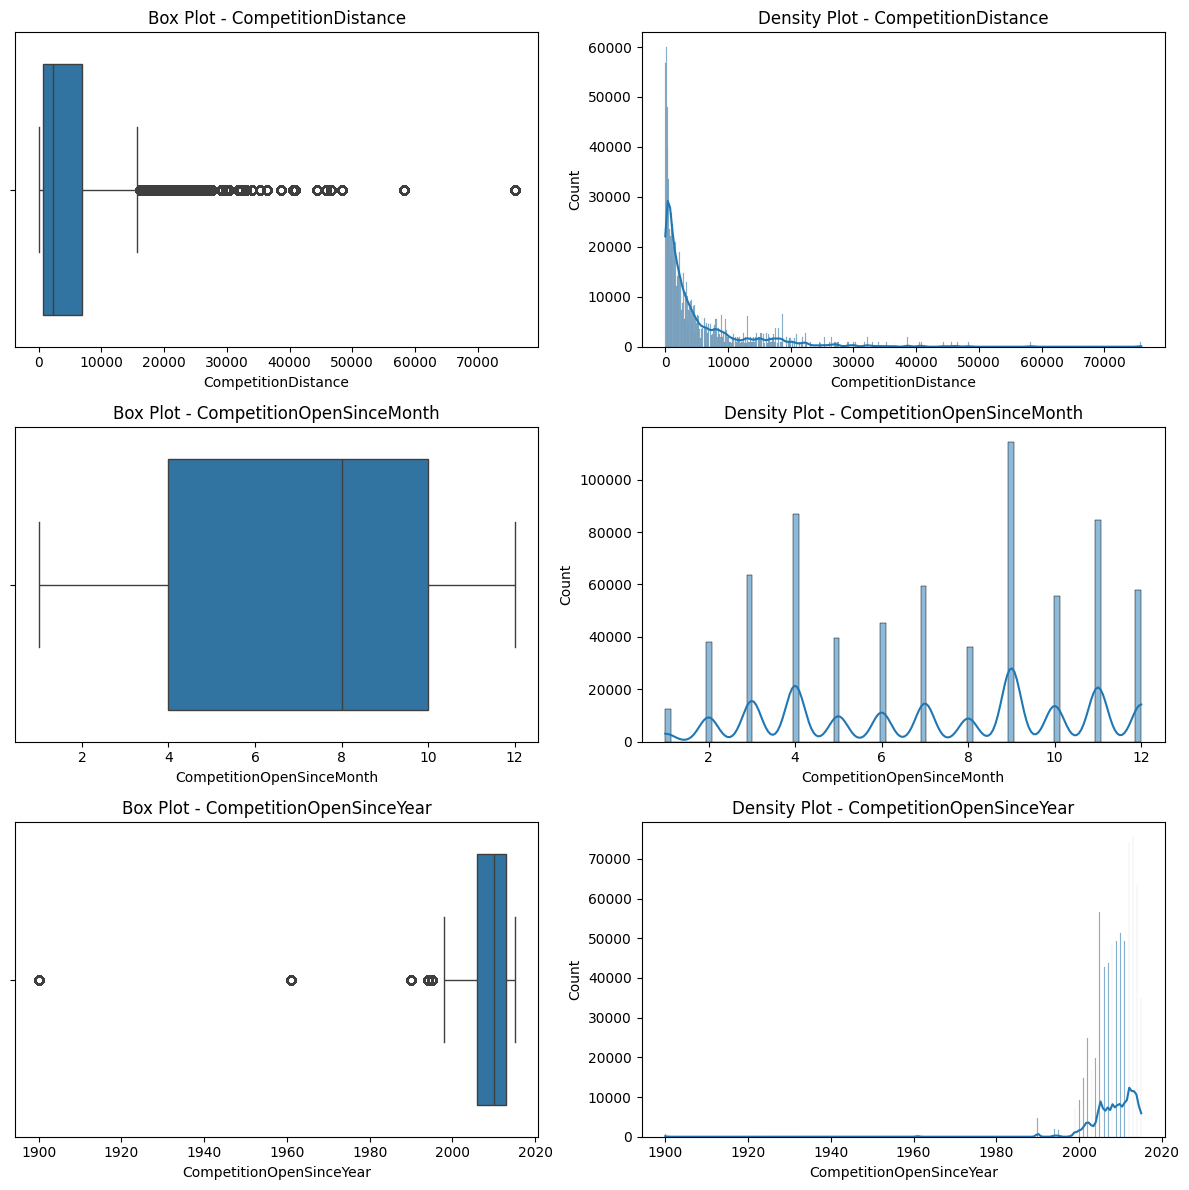

In [ ]:
lst = ['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']

show_box_density_plot(data,lst)




*   Since 'CompetitionDistance' is highly skewed so the Null values in the column should be replaced by the **median** value of the column.
*   Since 'CompetitionOpenSinceMonth' is neither skewed nor normally distributed so the Null values in the column should be replaced by the **mode** value of the column since the median is less sensitive to the extreme values as compared to mean.

*   Since 'CompetitionOpenSinceYear' is highly skewed so the Null values in the column should be replaced by the **mode** value of the column.







In [ ]:
data['CompetitionDistance'].fillna(data['CompetitionDistance'].median(),inplace = True)
data['CompetitionOpenSinceMonth'].fillna(data['CompetitionOpenSinceMonth'].mode()[0],inplace = True)
data['CompetitionOpenSinceYear'].fillna(data['CompetitionOpenSinceYear'].mode()[0],inplace = True)

In [ ]:
data[lst].isnull().sum()

CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
dtype: int64

In [ ]:
for col in list(data.columns):
  print('Unique values in {}: {}'.format(col,data[col].unique()))
  print('--'*30)

Unique values in Store: [   1    2    3 ... 1113 1114 1115]
------------------------------------------------------------
Unique values in DayOfWeek: [5 4 3 2 1 7 6]
------------------------------------------------------------
Unique values in Date: ['2015-07-31' '2015-07-30' '2015-07-29' '2015-07-28' '2015-07-27'
 '2015-07-26' '2015-07-25' '2015-07-24' '2015-07-23' '2015-07-22'
 '2015-07-21' '2015-07-20' '2015-07-19' '2015-07-18' '2015-07-17'
 '2015-07-16' '2015-07-15' '2015-07-14' '2015-07-13' '2015-07-12'
 '2015-07-11' '2015-07-10' '2015-07-09' '2015-07-08' '2015-07-07'
 '2015-07-06' '2015-07-05' '2015-07-04' '2015-07-03' '2015-07-02'
 '2015-07-01' '2015-06-30' '2015-06-29' '2015-06-28' '2015-06-27'
 '2015-06-26' '2015-06-25' '2015-06-24' '2015-06-23' '2015-06-22'
 '2015-06-21' '2015-06-20' '2015-06-19' '2015-06-18' '2015-06-17'
 '2015-06-16' '2015-06-15' '2015-06-14' '2015-06-13' '2015-06-12'
 '2015-06-11' '2015-06-10' '2015-06-09' '2015-06-08' '2015-06-07'
 '2015-06-06' '2015-06-05

####*  **Modifying Data types of required column**

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

data['CompetitionOpenSinceMonth'] = data['CompetitionOpenSinceMonth'].astype(int)
data['CompetitionOpenSinceYear'] = data['CompetitionOpenSinceYear'].astype(int)

data['StateHoliday'].replace(['a','b','c'], 1, inplace=True)
data['StateHoliday'] = data['StateHoliday'].astype(int)

print('Date: ',data['Date'].dtype)
print('CompetitionOpenSinceMonth: ',data['CompetitionOpenSinceMonth'].dtype)
print('CompetitionOpenSinceYear: ',data['CompetitionOpenSinceYear'].dtype)
print('StateHoliday: ',data['StateHoliday'].dtype)

Date:  datetime64[ns]
CompetitionOpenSinceMonth:  int64
CompetitionOpenSinceYear:  int64
StateHoliday:  int64


####* **Droping columns with around 50% Null values and Date column**

In [ ]:
data.shape

(1017209, 18)

In [ ]:
data.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [ ]:
data.skew()

Store                       -0.000955
DayOfWeek                    0.001593
Sales                        0.641460
Customers                    1.598650
Open                        -1.758045
Promo                        0.487838
StateHoliday                 5.458198
SchoolHoliday                1.677842
CompetitionDistance          2.933466
CompetitionOpenSinceMonth   -0.714064
CompetitionOpenSinceYear    -7.884662
Promo2                      -0.002255
Promo2SinceWeek              0.104528
Promo2SinceYear             -0.120060
dtype: float64

**Extracting Features**

In [ ]:
data['WeekOfYear'] = data['Date'].dt.week
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

data['CompetitionDurationMonths'] = (data['Year'] - data['CompetitionOpenSinceYear']) * 12 + (data['Month'] - data['CompetitionOpenSinceMonth'])
data['Promotions'] = data['Promo']+data['Promo2']

**Checking CompetitionDurationMonths distribution**

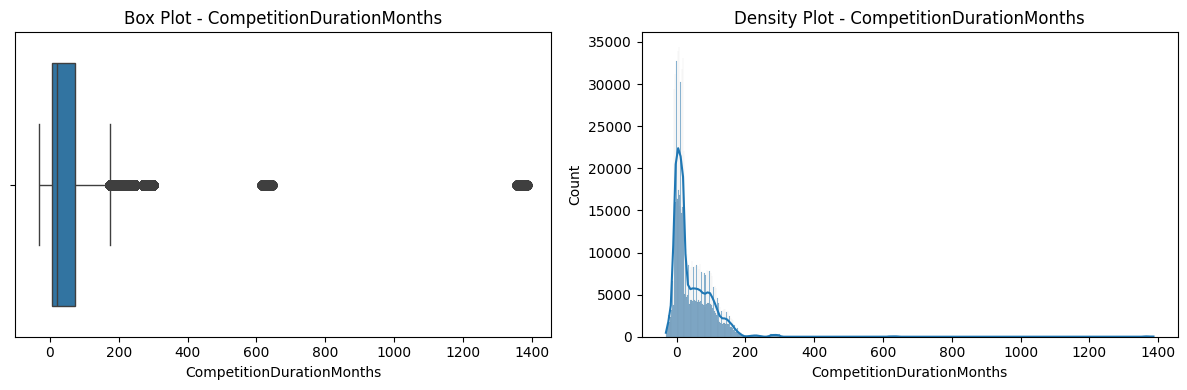

In [ ]:
show_box_density_plot(data,['CompetitionDurationMonths'])

In [ ]:
data[data.CompetitionDurationMonths<0].loc[:, ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceYear']]

CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2SinceYear
687                              8                      2015           2011.0
1019                             8                      2015              NaN
1071                             8                      2015           2010.0
1802                             8                      2015           2011.0
2134                             8                      2015              NaN
...                            ...                       ...              ...
1017193                          9                      2013           2011.0
1017204                          6                      2014           2013.0
1017206                          9                      2013              NaN
1017207                          9                      2013              NaN
1017208                          9                      2013           2012.0

[170688 rows x 3 columns]

We can clearly see that the Competetive stores were established earlier than the Rossmann stores hence the values in CompetitionDurationMonths were negative


**Let's change the negative values in the CompetitionDurationMonths to 0**

In [ ]:
data['CompetitionDurationMonths']= data['CompetitionDurationMonths'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
data.drop(columns = ['Promo2SinceWeek','Promo2SinceYear','PromoInterval'],axis =1,inplace= True)

**Looking for Refurbishments in the dataset**

In [ ]:
data[(data.SchoolHoliday ==1) & (data.StateHoliday==0)].Open.value_counts(normalize=True)*100

1    98.154744
0     1.845256
Name: Open, dtype: float64

In [ ]:
data[(data.SchoolHoliday ==0) & (data.StateHoliday==1)].Open.value_counts(normalize=True)*100

0    96.164489
1     3.835511
Name: Open, dtype: float64

In [ ]:
data[(data.SchoolHoliday ==1) & (data.StateHoliday==1)].Open.value_counts(normalize=True)*100

0    97.97563
1     2.02437
Name: Open, dtype: float64

In [ ]:
data[(data.SchoolHoliday ==0) & (data.StateHoliday==0)].Open.value_counts(normalize=True)*100

1    82.973331
0    17.026669
Name: Open, dtype: float64

In [ ]:
data['Holiday'] = np.where(((data.SchoolHoliday==1)&(data.StateHoliday==1)),1,0)
data.Holiday.value_counts(normalize=True)*100

0    98.475141
1     1.524859
Name: Holiday, dtype: float64

In [ ]:
data.groupby('Holiday')['Open'].value_counts(normalize=True)*100

Holiday  Open
0        1       84.264719
         0       15.735281
1        0       97.975630
         1        2.024370
Name: Open, dtype: float64

In [ ]:
data.groupby('Holiday')['Open'].value_counts()

Holiday  Open
0        1       844078
         0       157620
1        0        15197
         1          314
Name: Open, dtype: int64

###Finding and droping Refurbishment data

In [ ]:
no_sales_data = data[(data.Holiday==0)&(data.Open==0)&(data.Sales==0)]

no_sales_data['Date'] = pd.to_datetime(no_sales_data['Date'])

# Sort the DataFrame by date for easier analysis
no_sales_data.sort_values('Date', inplace=True)

# Initialize variables
refurbishment_data_indices = []
current_range = [no_sales_data.index[0]]

# Iterate through the DataFrame to identify consecutive date ranges
for i in range(1, len(no_sales_data)):
    if (no_sales_data['Date'].iloc[i - 1] + pd.Timedelta(days=1)) == no_sales_data['Date'].iloc[i]:
        current_range.append(no_sales_data.index[i])
    else:
        # Consecutive dates break, start a new range
        if len(current_range) > 1:
            refurbishment_data_indices.append(current_range)
        current_range = [no_sales_data.index[i]]

# Check and append the last range if needed
if len(current_range) > 1:
    refurbishment_data_indices.append(current_range)

# Flatten the list of lists
refurbishment_data_indices = [index for sublist in refurbishment_data_indices for index in sublist]

# Print the identified refurbishment data indices
print("Number of Retail shops under Refurbishment in original data :",end = '')
print(len(refurbishment_data_indices))


Number of Retail shops under Refurbishment in original data :1128


##**Exploratory Data Analysis(EDA)**

In [ ]:
data.shape

(1017209, 21)

###**Univariate Analysis**

In [ ]:

try:
  def apply_percent(axes):
    '''Takes axes as input and labels the percent count of each bar in a countplot'''
    for p in plot.patches:
        total = sum(p.get_height() for p in plot.patches)/100
        percent = round((p.get_height()/total),2)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        plot.annotate(f'{percent}%', (x, y), ha='center', va='bottom')
except:
    print ("An error occurred")

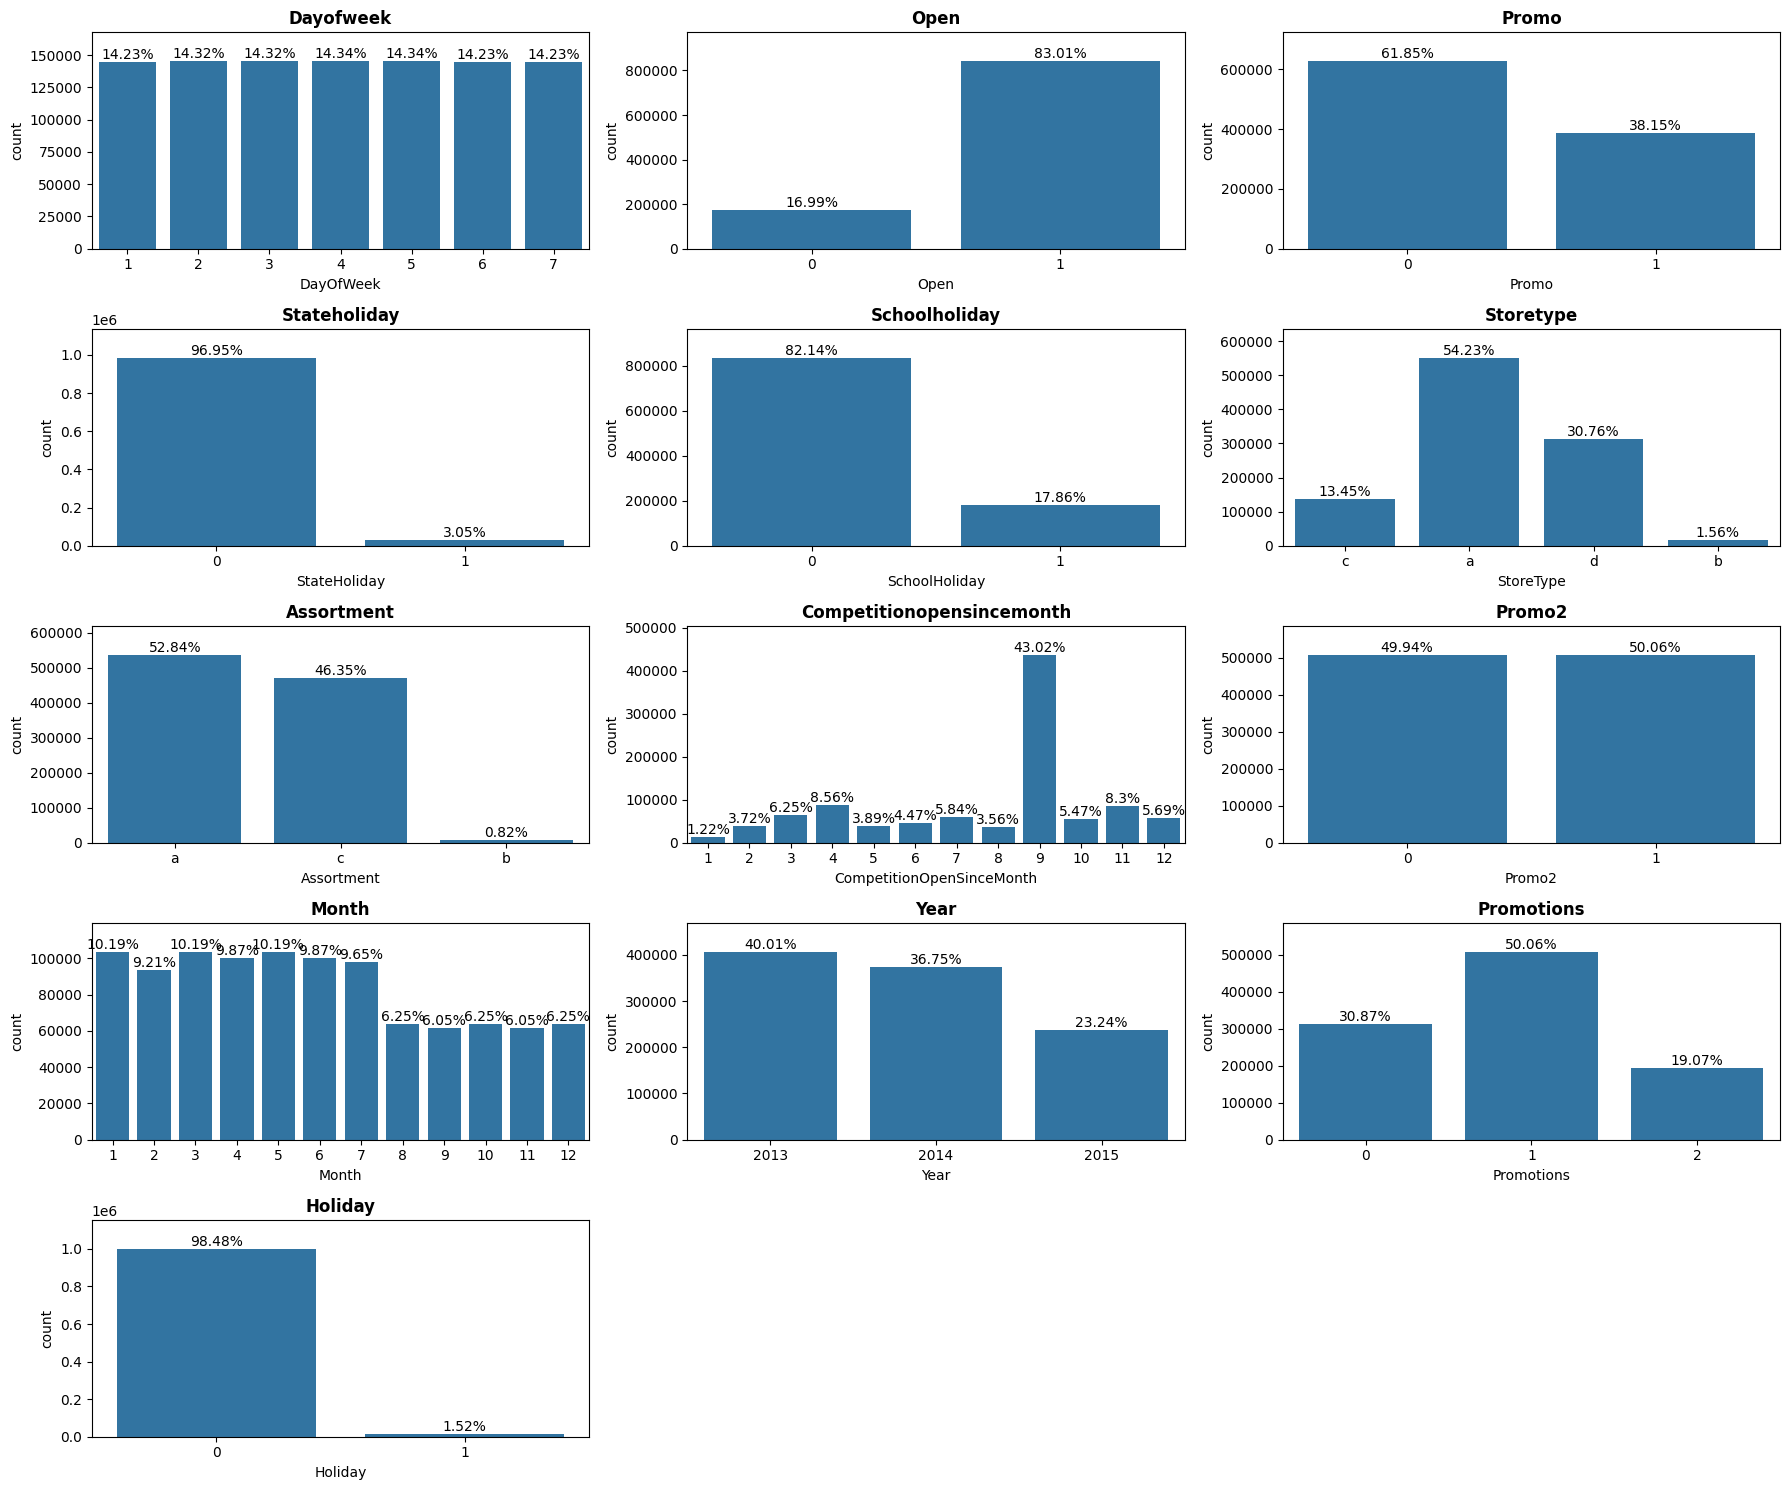

In [ ]:
req_features = [col for col in data.columns if len(data[col].value_counts())<=15]
r = int(len(req_features)/3 +1)

'''Plotting graphs for each feature in the req_feature list. '''

plt.figure(figsize=(18,r*3))
for n,var in enumerate(req_features):
    plot = plt.subplot(r,3,n+1)
    sns.countplot(x=data[var]).margins(y=0.15)
    plt.title(f'{var.title()}',weight='bold')
    plt.tight_layout()

    apply_percent(plot)

###**Bivariate Analysis**

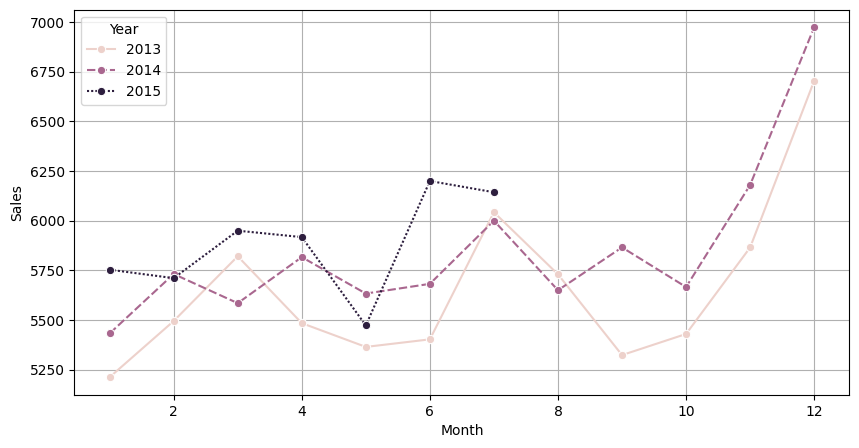

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x="Month", y="Sales",
             hue="Year", style="Year", marker ='o',ci =None,
             data=data)
plt.grid()
plt.show()

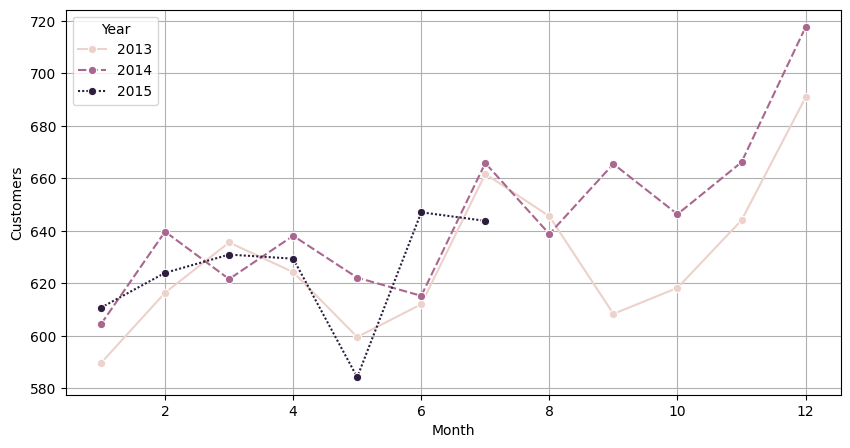

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x="Month", y="Customers",
             hue="Year", style="Year", marker ='o',ci =None,
             data=data)
plt.grid()
plt.show()

Text(0.5, 1.0, 'Customers vs CompetitionOpenSinceYear')

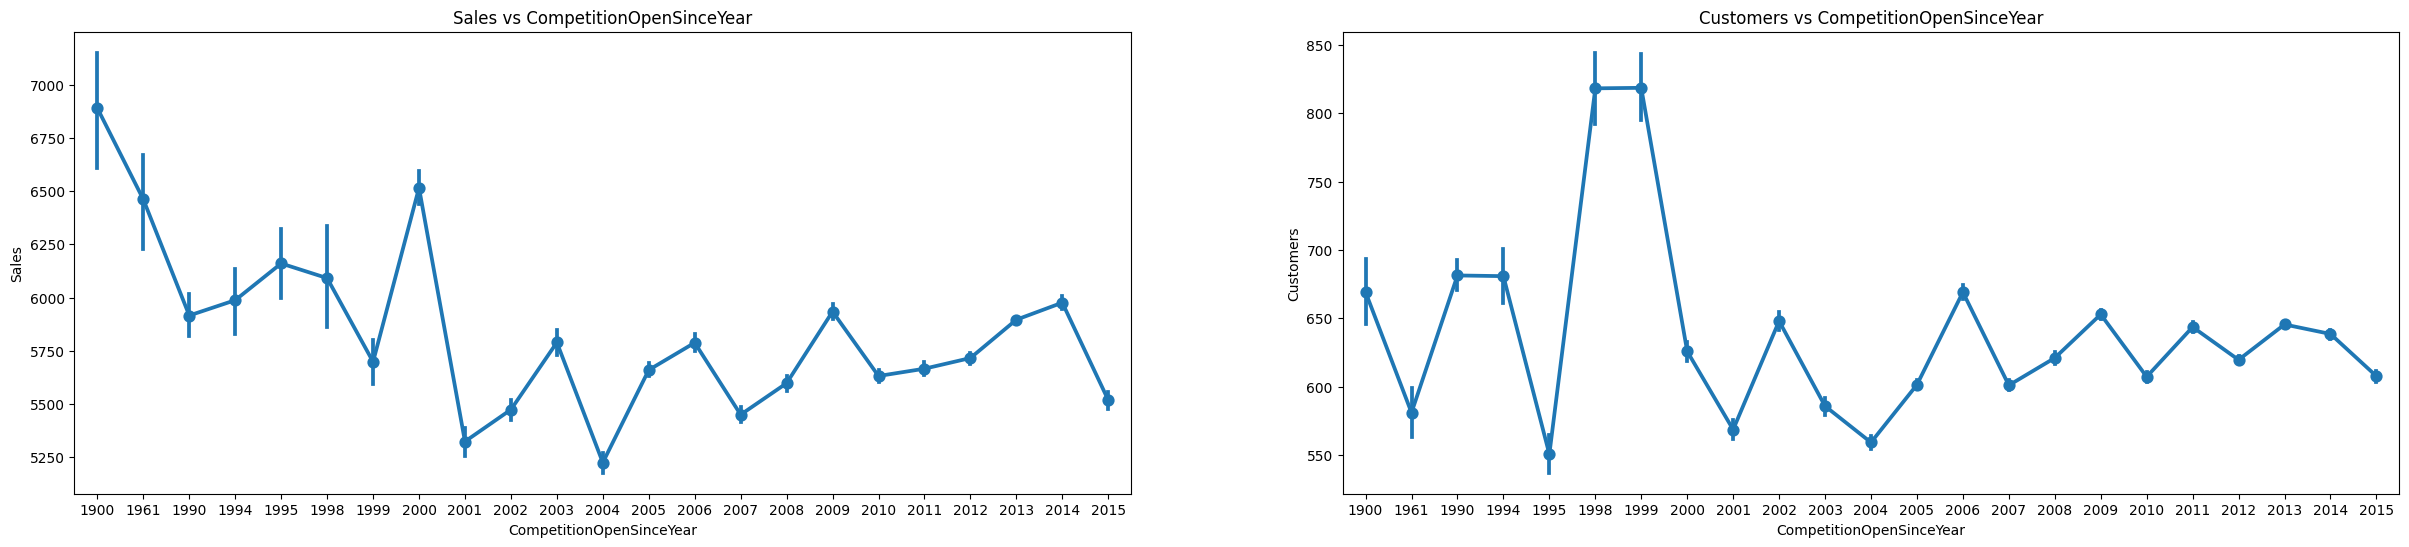

In [ ]:
# plot point plot for CompetitionOpenSinceYear & Promo2SinceYear

fig, axes = plt.subplots(1, 2, figsize=(30,6))

# plot point plot for Sales
sns.pointplot( x='CompetitionOpenSinceYear', y='Sales',ax=axes[0], data=data)
axes[0].set_title(f'Sales vs CompetitionOpenSinceYear')

# plot point plot for Customers
sns.pointplot(x='CompetitionOpenSinceYear', y='Customers',ax=axes[1], data=data)
axes[1].set_title(f'Customers vs CompetitionOpenSinceYear')

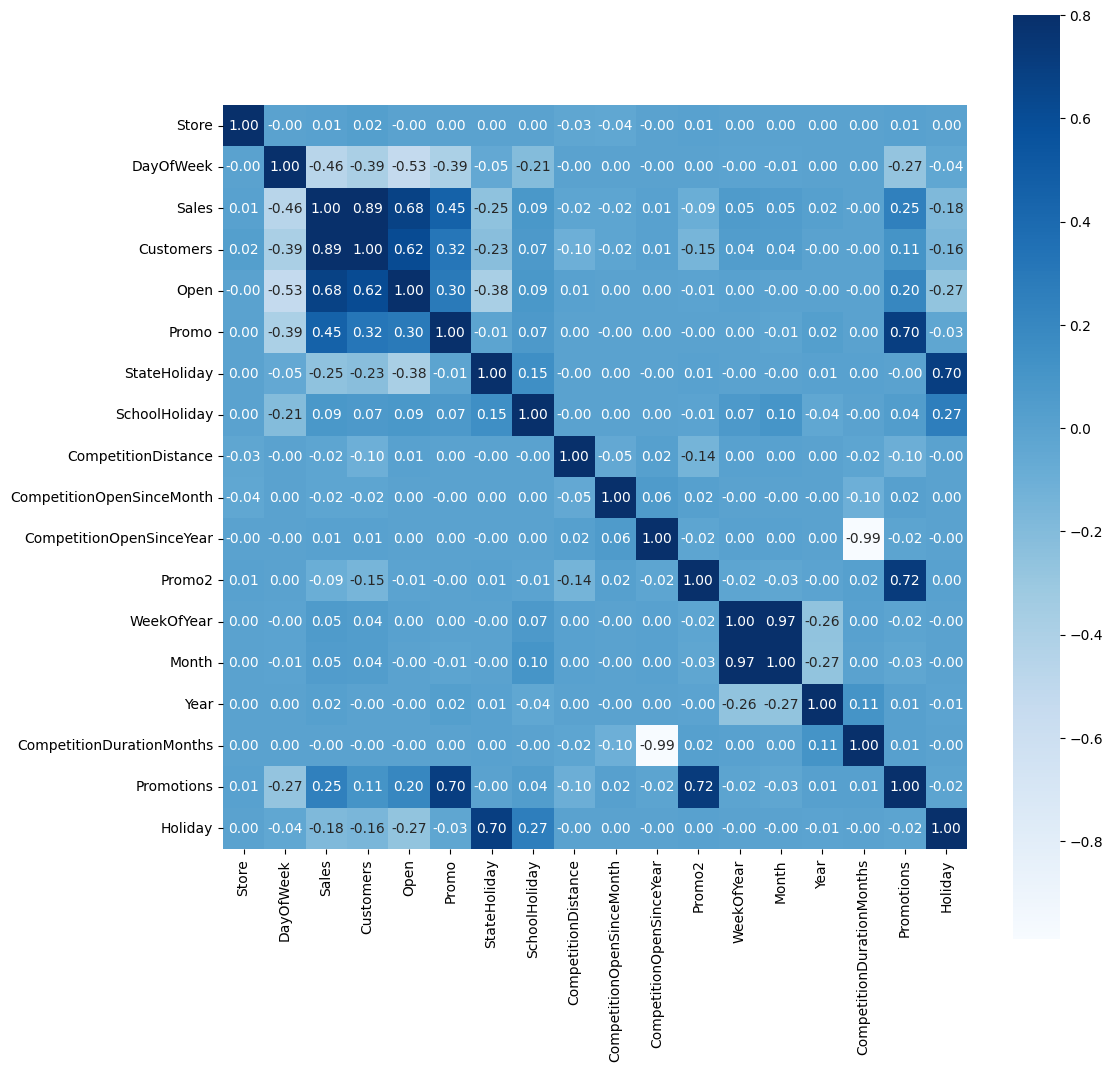

In [ ]:
corr_mat = data.corr()
fig, axes = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_mat, annot = True, fmt='.2f', annot_kws={'size': 10},  vmax=.8, square=True, cmap='Blues');

In [ ]:
data.drop(columns = ['Store','Date','Year','Month','CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis =1,inplace= True)

###**Outlier Detection and Treatment**

In [ ]:
# Finding categorical variables
categorical = [i for i in data.columns if data[i].dtypes=='O']
print('Total Categorical columns: ',len(categorical))
print(categorical)
print('**'*30)
# Finding Numeric variable
numeric = [i for i in data.columns if data[i].dtypes!='O']
print('Total Numerical columns: ',len(numeric))
print(numeric)

Total Categorical columns:  2
['StoreType', 'Assortment']
************************************************************
Total Numerical columns:  13
['DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'WeekOfYear', 'CompetitionDurationMonths', 'Promotions', 'Holiday']


In [ ]:
for col in numeric:
  print("number of unique values in {} is: {}".format(col,len(data[col].unique())))

number of unique values in DayOfWeek is: 7
number of unique values in Sales is: 21734
number of unique values in Customers is: 4086
number of unique values in Open is: 2
number of unique values in Promo is: 2
number of unique values in StateHoliday is: 2
number of unique values in SchoolHoliday is: 2
number of unique values in CompetitionDistance is: 654
number of unique values in Promo2 is: 2
number of unique values in WeekOfYear is: 52
number of unique values in CompetitionDurationMonths is: 336
number of unique values in Promotions is: 3
number of unique values in Holiday is: 2


####Creating **continuous_cols** and **discerte_num_cols** from **numeric** features based on a **rough assumption** that the features having **unique values less than 10** are considered under discrete_num_cols else considered under continuous_cols.

In [ ]:
continuous_cols = [col for col in numeric if (len(data[col].unique())> 10)]
print('Continuous variables: ',continuous_cols)
discrete_num_cols = [col for col in list(set(numeric)-set(continuous_cols))]
print('Discrete variables:',discrete_num_cols)

Continuous variables:  ['Sales', 'Customers', 'CompetitionDistance', 'WeekOfYear', 'CompetitionDurationMonths']
Discrete variables: ['Promo', 'StateHoliday', 'Open', 'SchoolHoliday', 'DayOfWeek', 'Promotions', 'Promo2', 'Holiday']


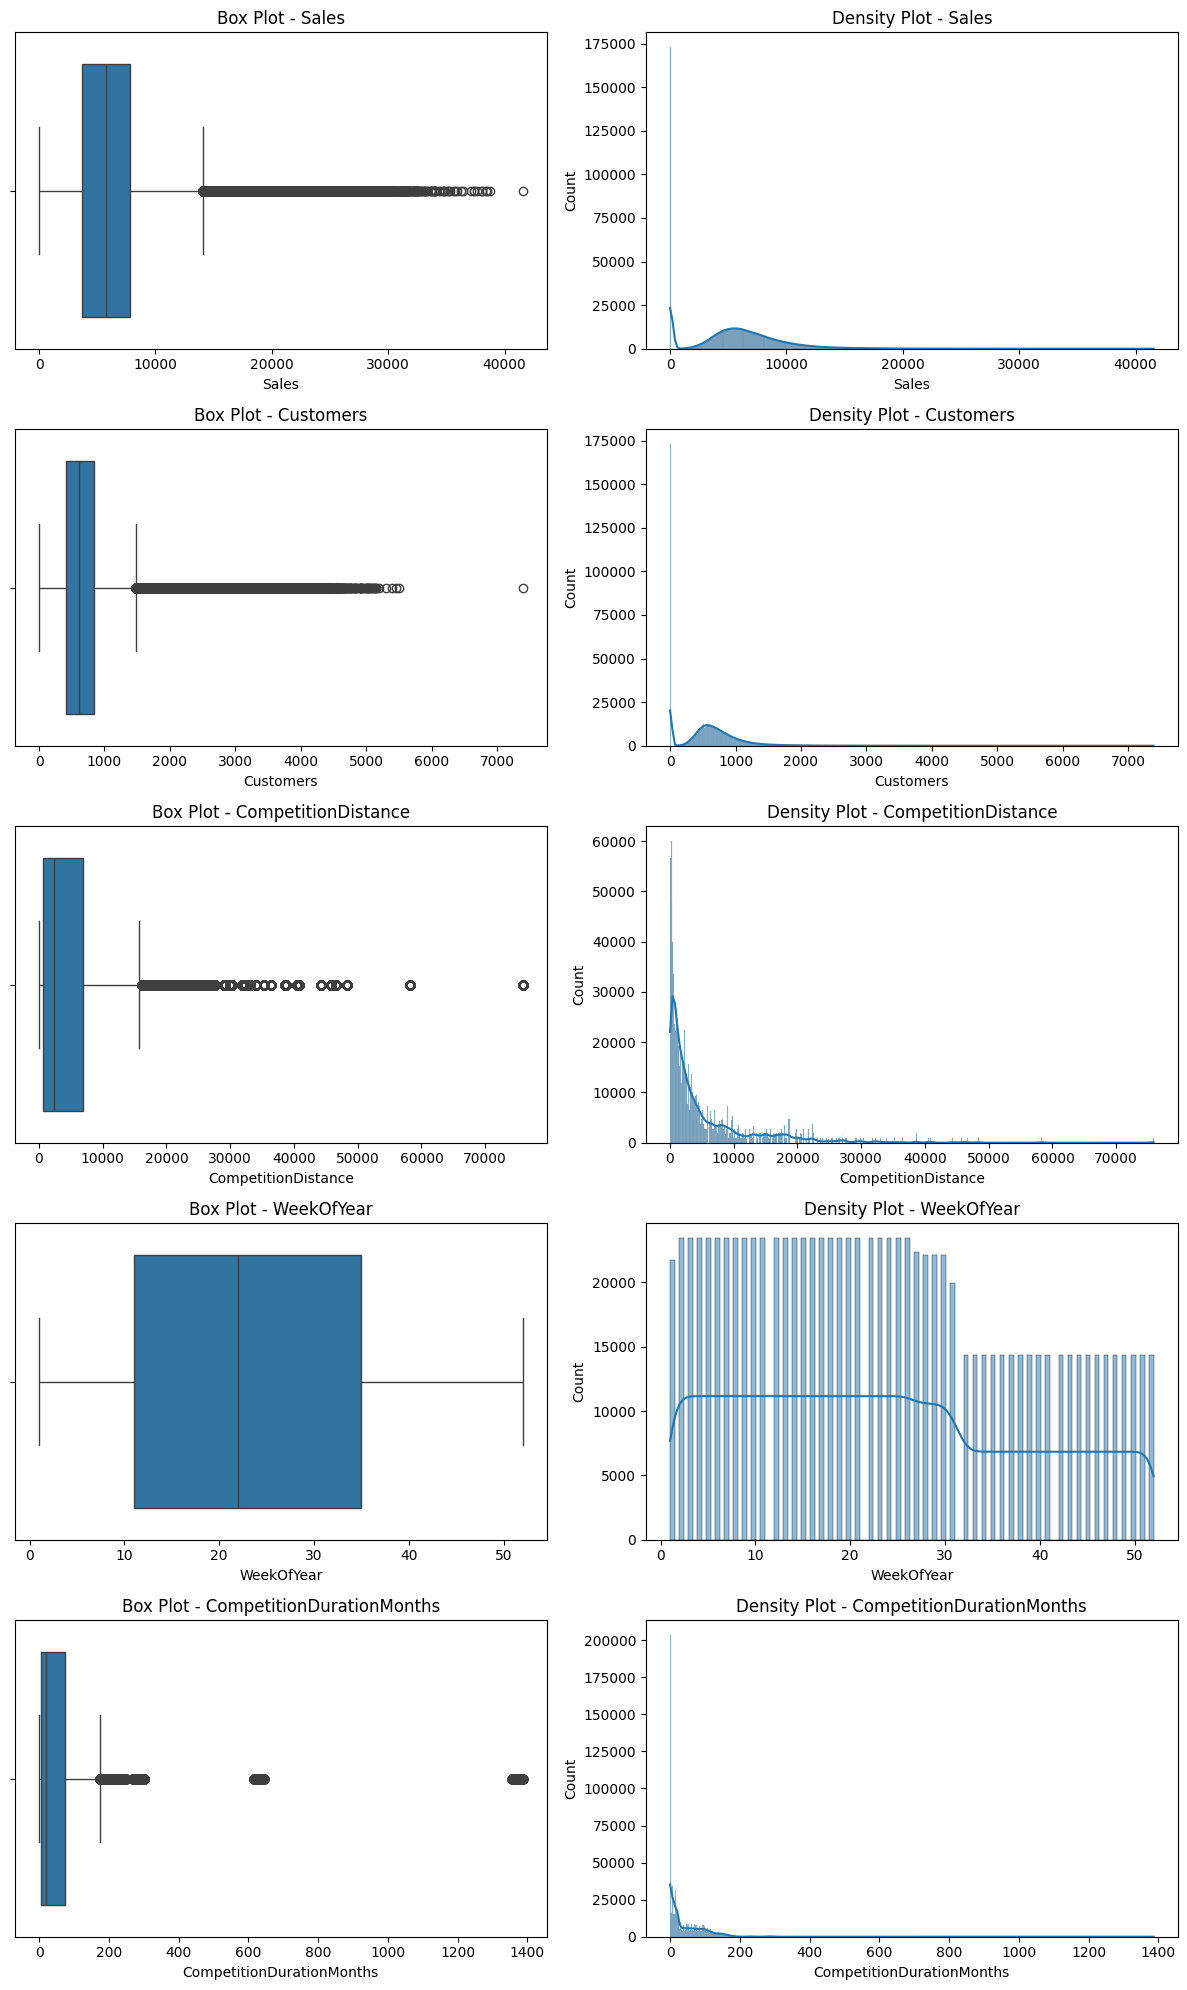

In [ ]:
show_box_density_plot(data,continuous_cols)

In [ ]:
data[continuous_cols].skew()

Sales                        0.641460
Customers                    1.598650
CompetitionDistance          2.933466
WeekOfYear                   0.278479
CompetitionDurationMonths    7.996473
dtype: float64

In [ ]:
outliers_in_features = ['Customers','CompetitionDistance','CompetitionDurationMonths']
for i in outliers_in_features:
  print(outlier_bounderies_percent(data,i))

(-243.0, 1485.0, '3.75%')
(-8545.0, 16135.0, '9.75%')
(-97.0, 175.0, '1.49%')


#### We will be removing these outliers from the Continuous numerical features later on..

In [ ]:
new_df = data.copy()

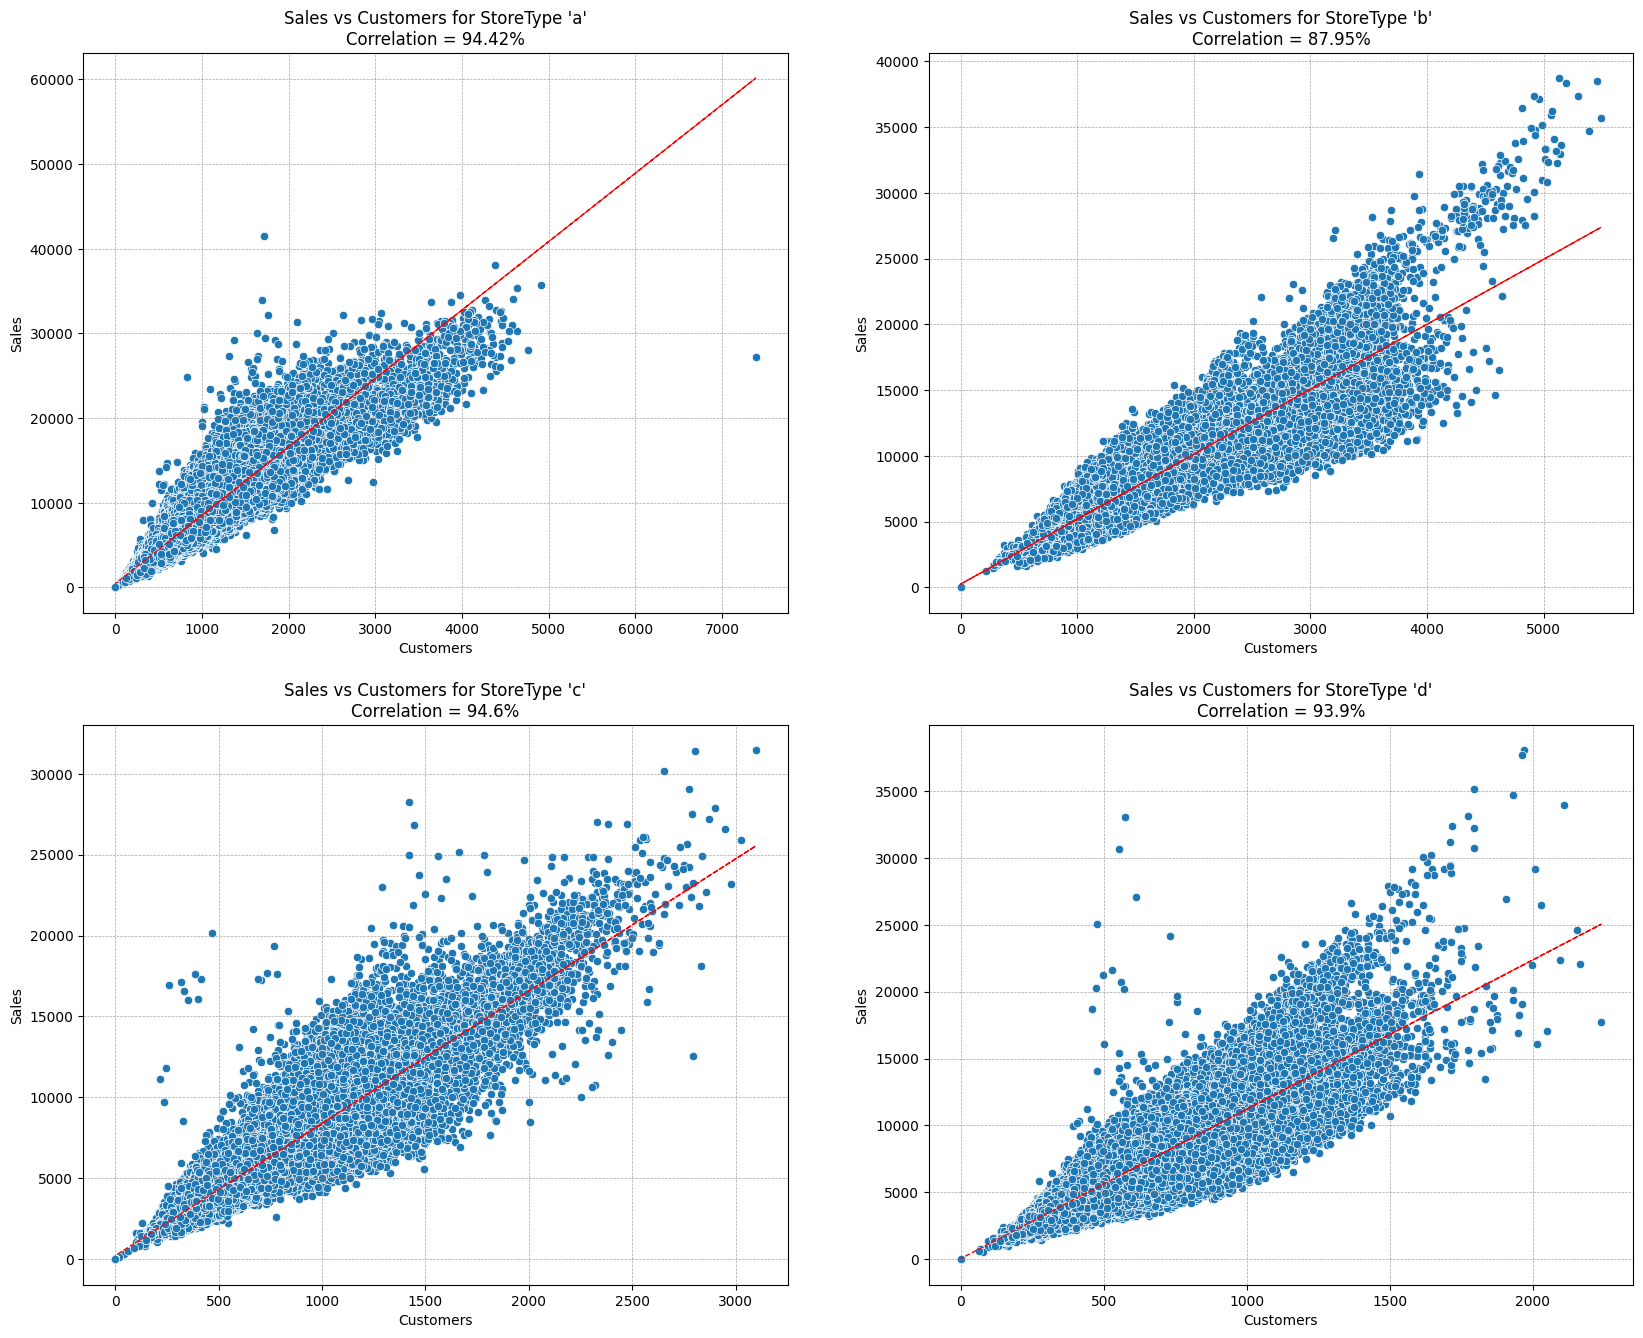

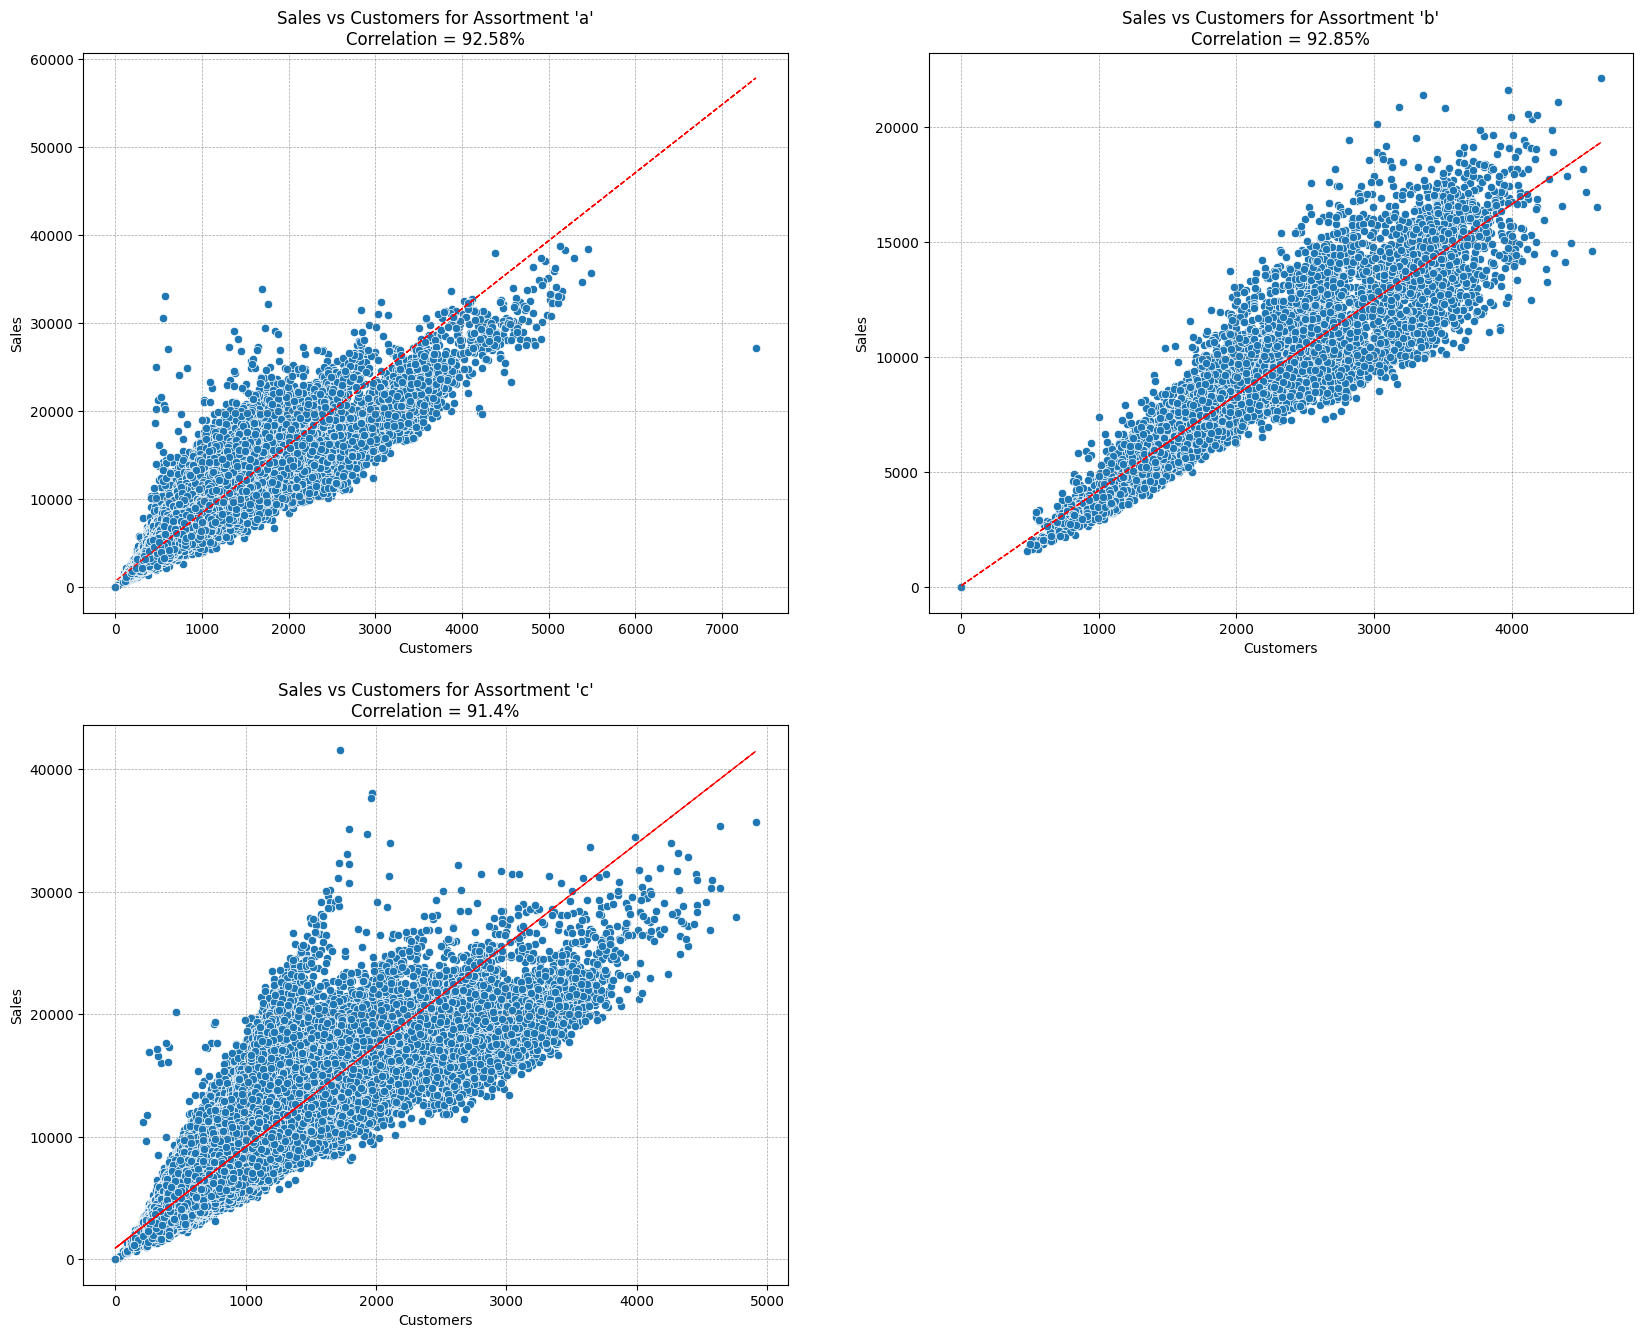

In [ ]:
categorical_features = ['StoreType', 'Assortment']

for i in categorical_features:
  sales_customers_vs_categorical_variable(new_df, i)


##**Filter for Categorical Features**

In [ ]:
Store_type_outliers_index = data[((data['StoreType']=='a')&((data.Customers>7000)|((data.Customers<2000)&(data.Sales>30000))))
|((data['StoreType']=='b')&(data.Customers>=5500))|
 ((data['StoreType']=='c')&((data.Customers>2750)|((data.Customers<500)&(data.Sales>9900))|
  (((data.Customers>500)&(data.Customers<1500))&(data.Sales>25000))))
|((data['StoreType']=='d')&(((data.Customers<500)&(data.Sales>14800))|((data.Customers>500)&(data.Customers<1000))&(data.Sales>17500)))].index

new_df.drop(Store_type_outliers_index,inplace=True)

Assortment_type_outlier_index = new_df[((new_df['Assortment']=='a')&((
     ((new_df.Customers<1000)&(new_df.Sales>23000))|(((new_df.Customers>1000)&(new_df.Customers<2000))&(new_df.Sales>=23000)))))|
    ((new_df['Assortment']=='c')&
     (((new_df.Customers<500)&(new_df.Sales>8500))|(((new_df.Customers>=1800)&(new_df.Customers<2000))&(new_df.Sales>=30000))|
     (((new_df.Customers>2000)&(new_df.Customers<=2300))&(new_df.Sales>30000))))
      ].index

new_df.drop(Assortment_type_outlier_index,inplace=True)

In [ ]:
new_df.shape

(1017059, 15)

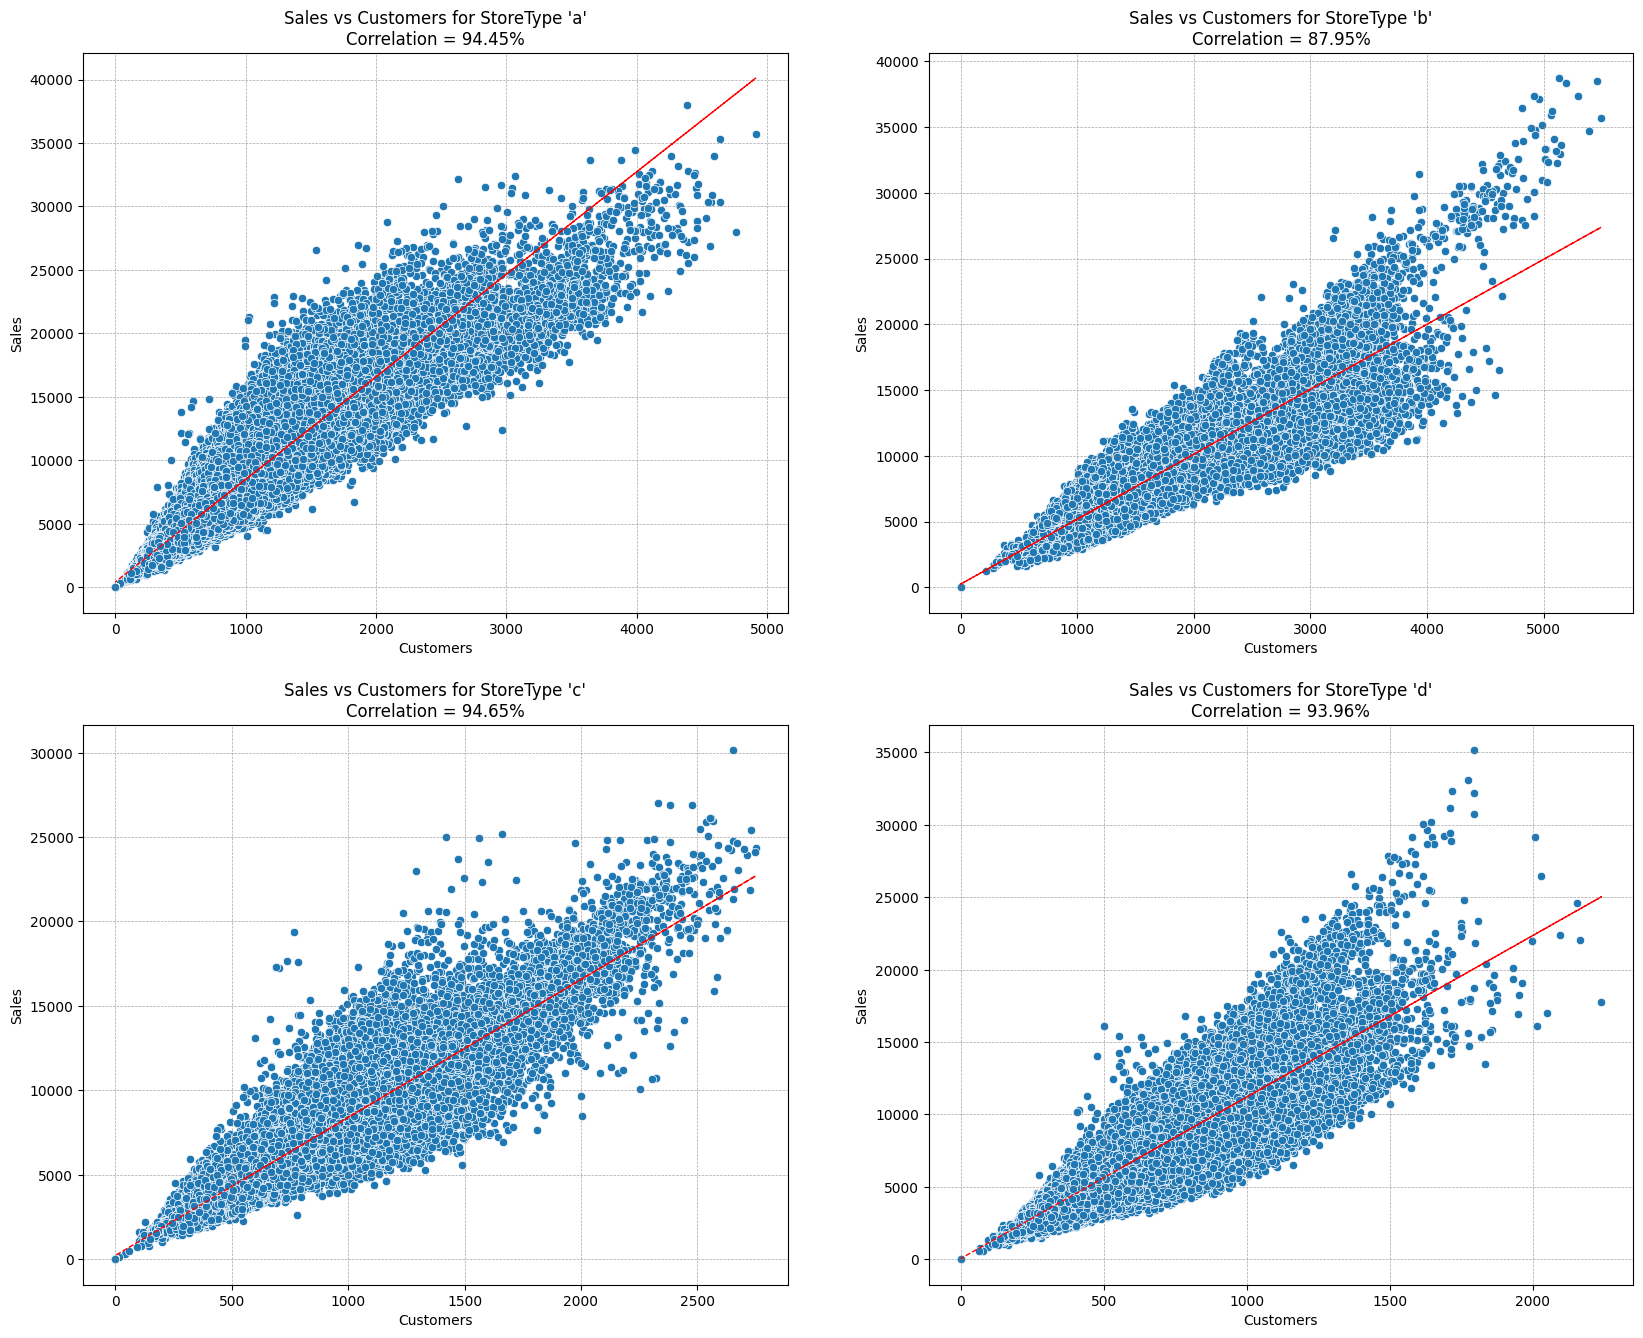

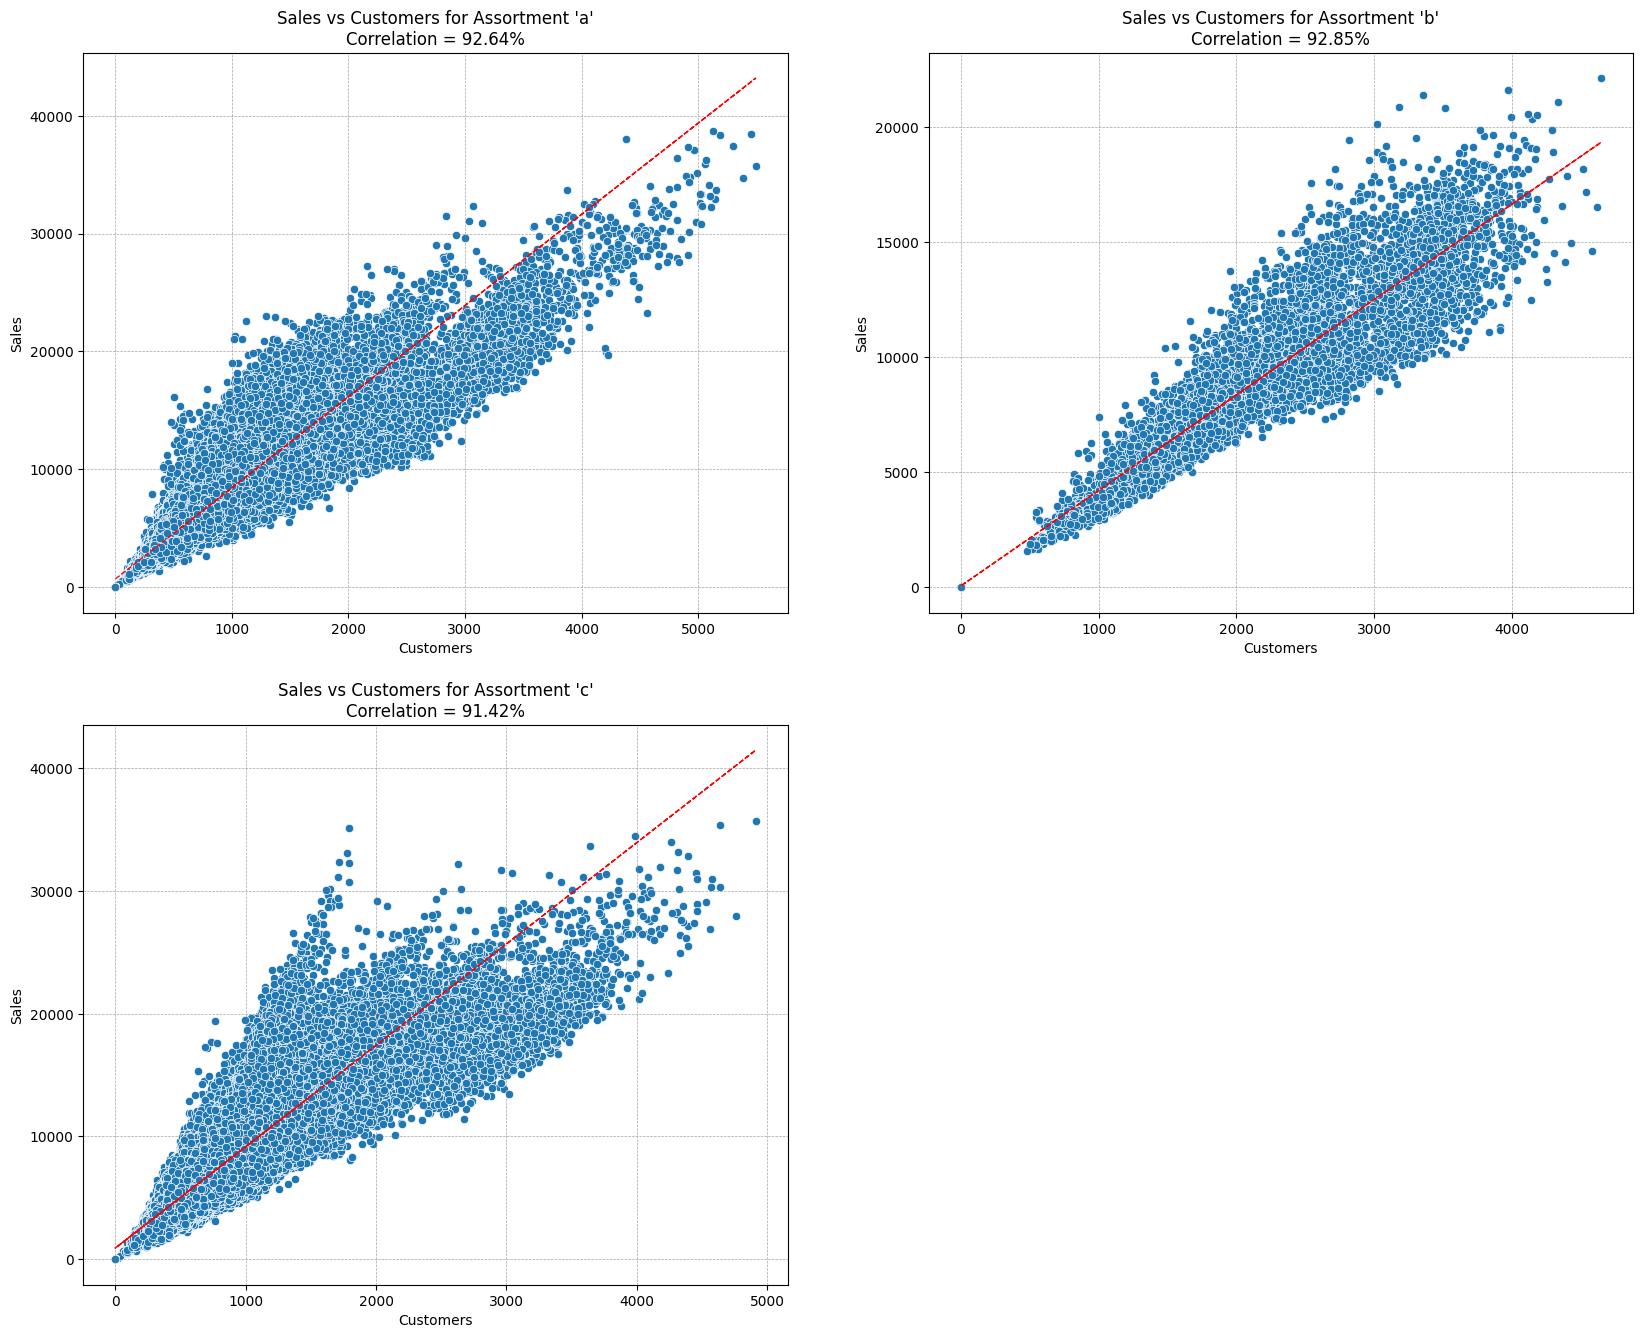

In [ ]:
for i in categorical_features:
  sales_customers_vs_categorical_variable(new_df, i)

In [ ]:
outliers_in_features = ['Customers','CompetitionDistance','CompetitionDurationMonths']
for i in outliers_in_features:
  print(outlier_bounderies_percent(new_df,i))

(-243.0, 1485.0, '3.74%')
(-8545.0, 16135.0, '9.75%')
(-97.0, 175.0, '1.49%')


#### We can see that around **9.75%** of the values in the **CompetitionDistance** are outliers hence its better not to drop all of them as this would lead to loss of data.

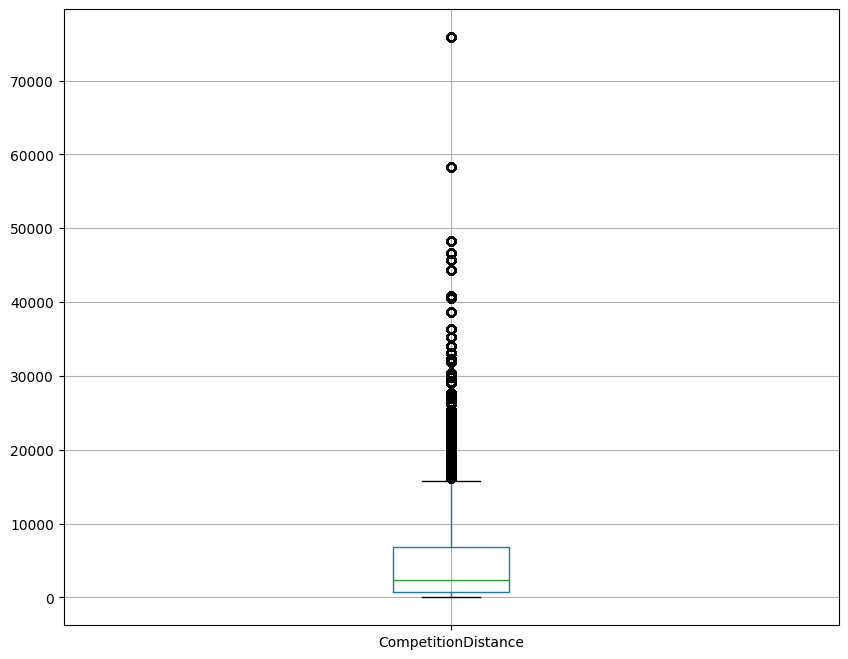

In [ ]:
show_box_plot(new_df,['CompetitionDistance'],10,8)

#### Since we can not eleminate entire outliers from the **CompetitionDistance** feature as this may overfit the model hence we will eleminate values beyond certain range say **30000-40000**.

In [ ]:
for val in [30000,32000,35000,36000,37000,37500,38000,40000,42000]:
  count = new_df[new_df['CompetitionDistance'] > val].shape[0]
  percent = round(count/new_df.shape[0]*100, 2)
  print(f"Count & percentage of data above {val} : {count} ({percent}%)")

Count & percentage of data above 30000 : 17897 (1.76%)
Count & percentage of data above 32000 : 15071 (1.48%)
Count & percentage of data above 35000 : 11303 (1.11%)
Count & percentage of data above 36000 : 10361 (1.02%)
Count & percentage of data above 37000 : 9419 (0.93%)
Count & percentage of data above 37500 : 9419 (0.93%)
Count & percentage of data above 38000 : 9419 (0.93%)
Count & percentage of data above 40000 : 7535 (0.74%)
Count & percentage of data above 42000 : 5652 (0.56%)


##**Filter for Numerical features**

In [ ]:
new_df = new_df[((new_df.Customers>=0) & (new_df.Customers<=1485))&((new_df.CompetitionDurationMonths>=0) & (new_df.CompetitionDurationMonths<=175))]

In [ ]:
new_df.shape

(964451, 15)

#### **Keeping only data which contains CompetitionDistance <= 36000**

In [ ]:
new_df = new_df[(new_df.CompetitionDistance>0)&(new_df.CompetitionDistance<=36000)]

In [ ]:
new_df.shape

(954228, 15)

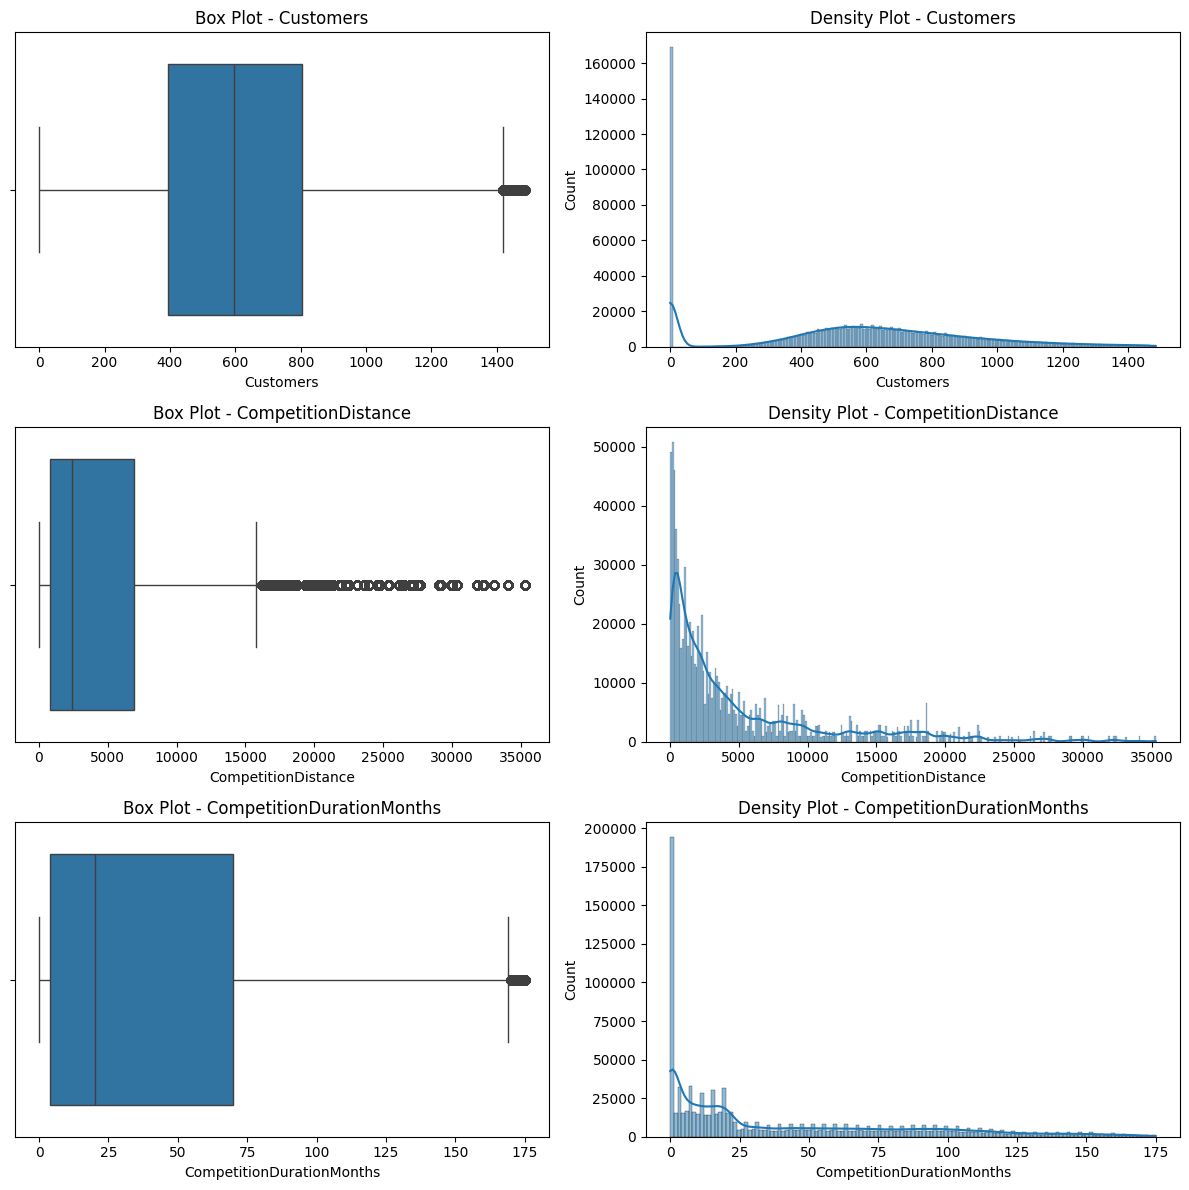

In [ ]:
show_box_density_plot(new_df,outliers_in_features)

#### We can see that there are still outliers in the above continuous variables but **removing all the outliers** from the above features may **overfit** the model.

In [ ]:
new_df.shape

(954228, 15)

####**Removing Refurbishment based data**

In [ ]:
refurbishment_index = [i for i in refurbishment_data_indices if i in new_df.index]

print('Number of records in new_df with stores under refurbishment is: ',len(refurbishment_index))

Number of records in new_df with stores under refurbishment is:  1112


In [ ]:
new_df.drop(refurbishment_index,inplace = True)

In [ ]:
new_df.shape

(953116, 15)

### **Feature Transformation**



*   In dataset we found outliers from various features and removed some of them to an extent because removal of all outliers from any given feature may lead to the problem of overfitting of the model. On the other hand presence of outliers in the features also skew the features.
*   Hence we will employ feature transformation techniques to remove skewness from the features.



####**Feature Transformation in Numerical features**

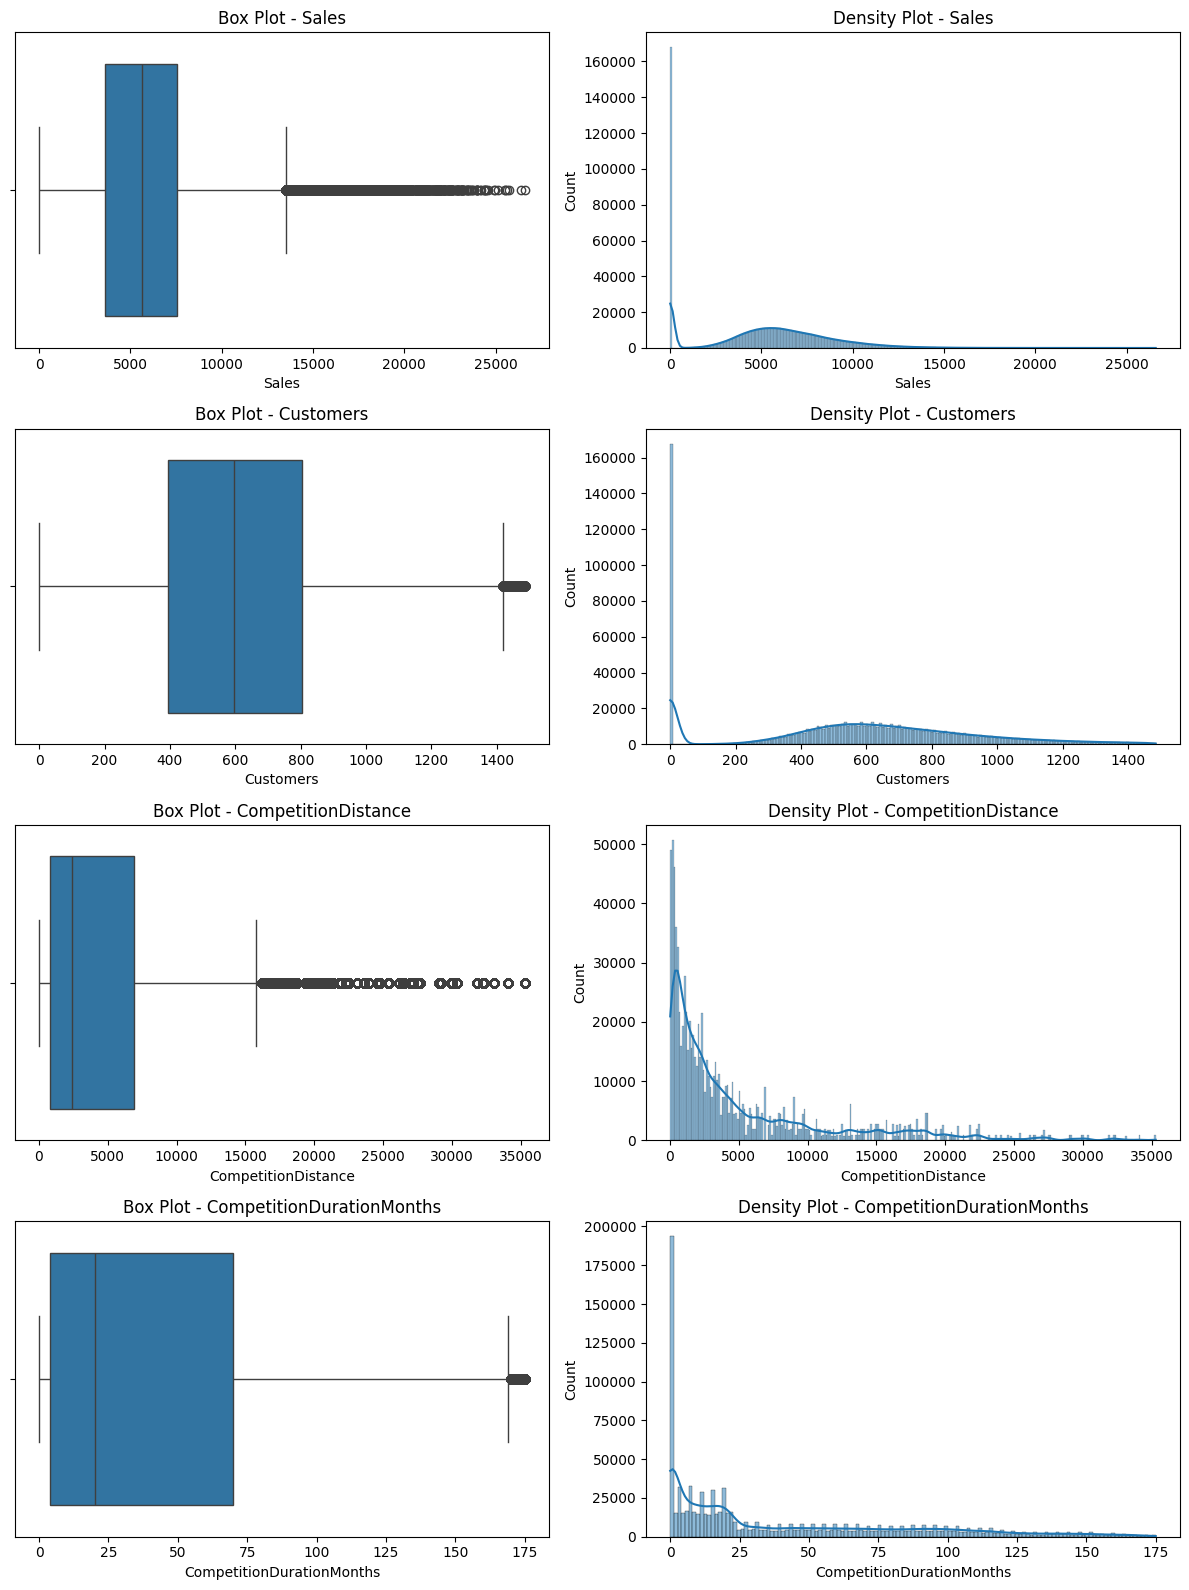

In [ ]:
continuous_variables=  ['Sales', 'Customers', 'CompetitionDistance', 'CompetitionDurationMonths']
show_box_density_plot(new_df,continuous_variables)

####**Feature Transformation in Categorical features**

In [ ]:
from sklearn.preprocessing import LabelEncoder
business_coder = LabelEncoder()
for feature in categorical_features:
   new_df[feature] = business_coder.fit_transform(new_df[feature])

In [ ]:
# new_df['Sales'] = new_df['Sales']**0.5

##Splitting the main data to **train** and **test** data

In [ ]:
X = new_df.drop(['Sales'],axis=1).copy()
y = pd.DataFrame(new_df['Sales'])

In [ ]:
X_train,X_loc_test,y_train,y_loc_test = train_test_split(X,y,test_size=0.40,random_state = 39)

In [ ]:
print("the number of rows and columns of X_train :",X_train.shape )
print("the number of rows and columns of X_loc_test :",X_loc_test.shape )
print("the number of rows and columns of y_train :",y_train.shape )
print("the number of rows and columns of y_loc_test :",y_loc_test.shape )

the number of rows and columns of X_train : (571869, 14)
the number of rows and columns of X_loc_test : (381247, 14)
the number of rows and columns of y_train : (571869, 1)
the number of rows and columns of y_loc_test : (381247, 1)


In [ ]:
X_train.reset_index(drop=True)
y_train.reset_index(drop = True)

Sales
0        7044
1        6351
2           0
3        3672
4        4668
...       ...
571864   4780
571865   9093
571866   6278
571867   5352
571868   9055

[571869 rows x 1 columns]

####Splitting the "X_loc_test" and "y_loc_test" dataset into "Test" and "Validation" dataframe with 50:50 format

In [ ]:
X_val,X_test,y_val,y_test = train_test_split(X_loc_test,y_loc_test,test_size=0.50)

X_test.reset_index(drop=True)
y_test.reset_index(drop = True)
X_val.reset_index(drop=True)
y_val.reset_index(drop = True)

Sales
0        7941
1        3289
2        4374
3        6231
4           0
...       ...
190618      0
190619   6630
190620   3241
190621  13521
190622      0

[190623 rows x 1 columns]

### Feature Selection

<Axes: title={'center': 'Pearson Correlation of Features'}>

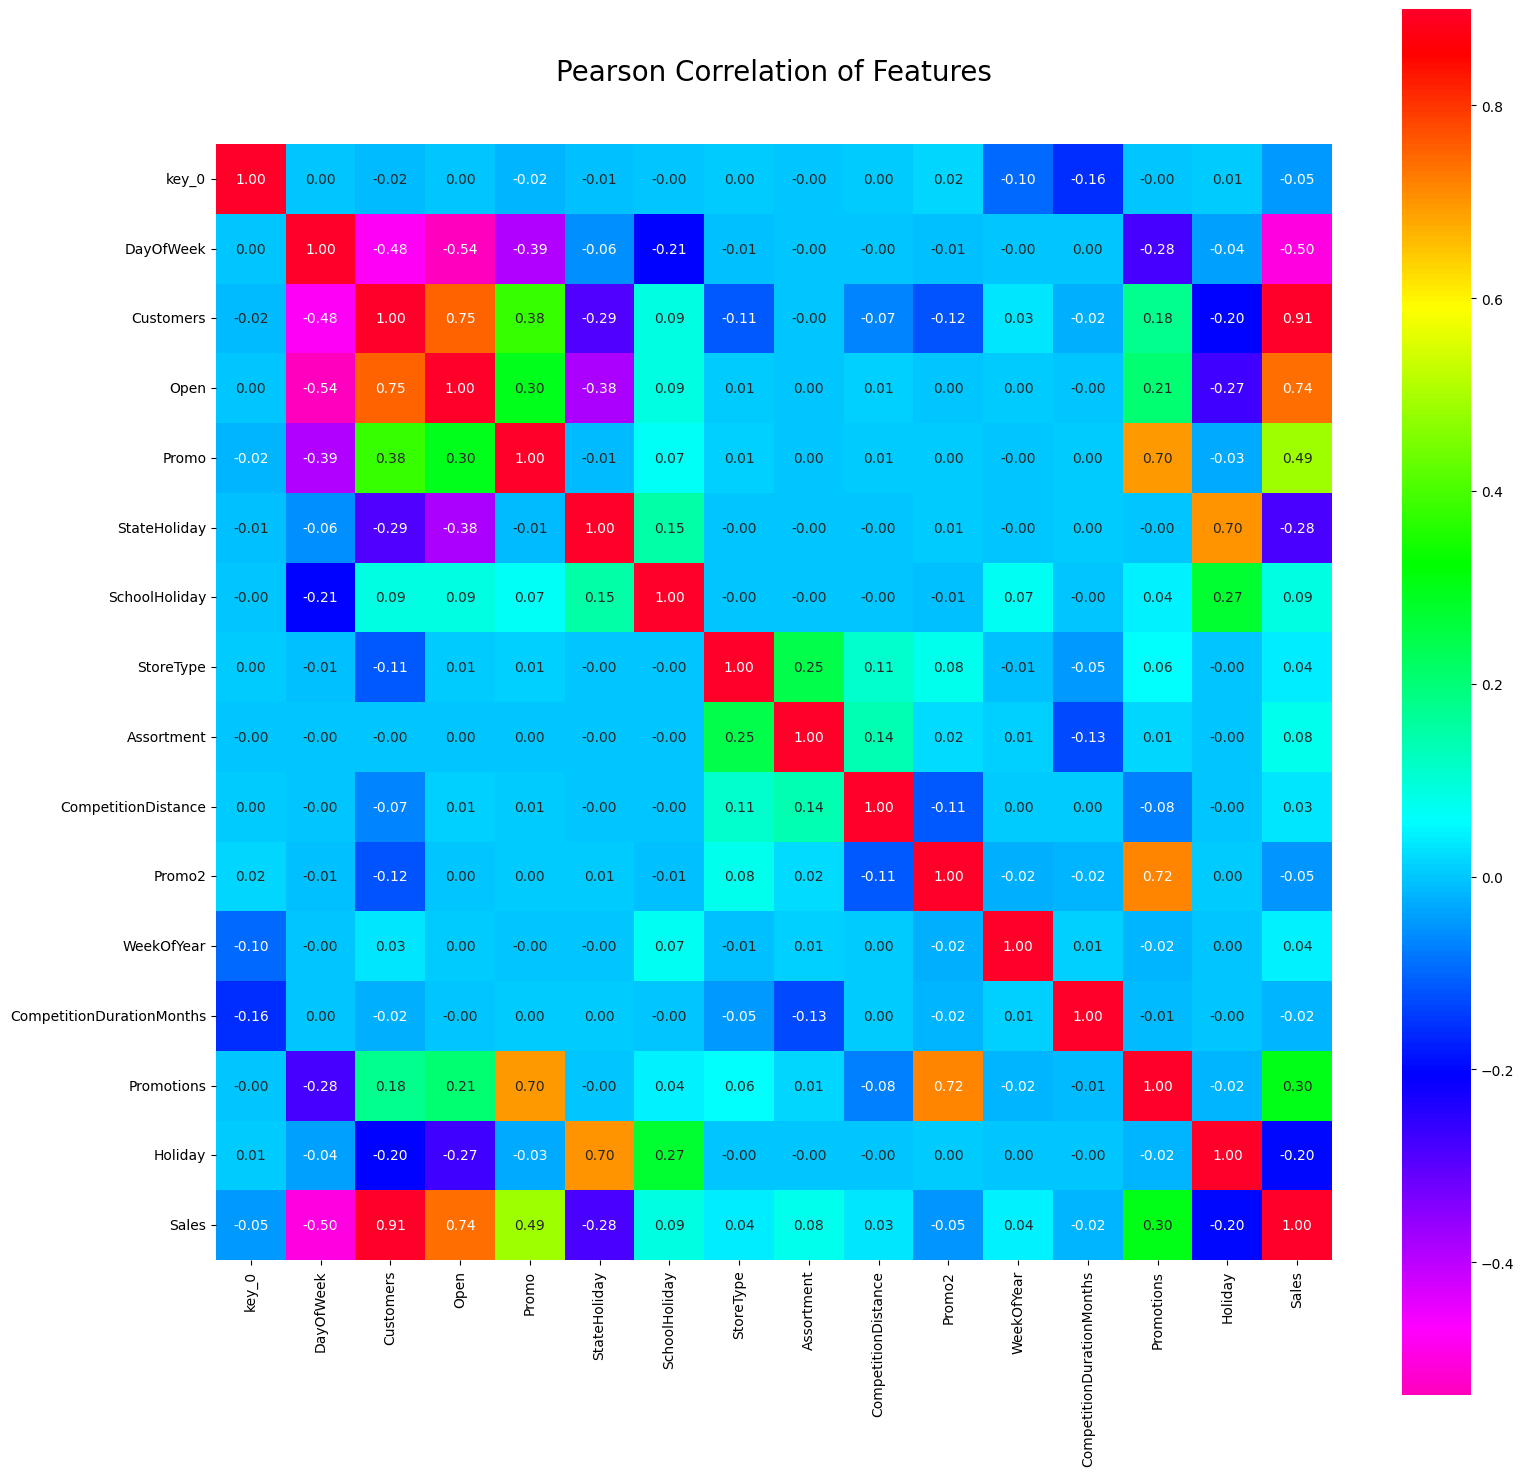

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(18,18))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(X_train.merge(y_train , on = X_train.index ).corr(),annot = True, fmt='.2f', annot_kws={'size': 10},  vmax=.9, square=True,cmap='gist_rainbow_r')

In [ ]:
def handling_correlation(X_train,threshold):
    corr_features = set()
    corr_matrix = X_train.corr()
    for i in range(len(corr_matrix .columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >threshold:
                colname = corr_matrix.columns[i]
                corr_features.add(colname)
    return list(corr_features)

In [ ]:
drop_features = handling_correlation(X_train,0.7)
drop_features

['Open', 'Promotions', 'Holiday']

In [ ]:
X_train.drop(columns = drop_features,axis=1,inplace = True)
X_val.drop(columns = drop_features,axis=1,inplace = True)
X_test.drop(columns = drop_features,axis=1,inplace = True)

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(0.8).fit(X_train)

In [ ]:
X_train.columns[selector.get_support()]

Index(['DayOfWeek', 'Customers', 'StoreType', 'Assortment',
       'CompetitionDistance', 'WeekOfYear', 'CompetitionDurationMonths'],
      dtype='object')

##**Modelling**

In [ ]:
def Model_Metrics(y_train,train_prediction,y_val,val_prediction,y_test,test_prediction):
  metrics = {}

  metrics['train_rmse'] = mean_squared_error(y_train, train_prediction, squared=False)
  metrics['train_r2'] = r2_score(y_train, train_prediction)

  metrics['val_rmse'] = mean_squared_error(y_val, val_prediction, squared=False)
  metrics['val_r2'] = r2_score(y_val, val_prediction)


  metrics['test_rmse'] = mean_squared_error(y_test, test_prediction, squared=False)
  metrics['test_r2'] = r2_score(y_test, test_prediction)

  return metrics

def results(metrics):
  print(f"Training Data\nR2    : {metrics['train_r2']}\nRMSE  : {metrics['train_rmse']}")
  print(f"\nValidation Data\nR2    : {metrics['val_r2']}\nRMSE  : {metrics['val_rmse']}")
  print(f"\nTesting Data\nR2    : {metrics['test_r2']}\nRMSE  : {metrics['test_rmse']}")


In [ ]:
MSE_Score = []
R2_Score = []
Algorithm = []
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [ ]:
Algorithm.append('LinearRegression')
regressor = LinearRegression()
regressor.fit(X_train, y_train)

train_prediction = regressor.predict(X_train)
val_prediction = regressor.predict(X_val)
test_prediction =  regressor.predict(X_test)

In [ ]:
metrics = Model_Metrics(y_train,train_prediction,y_val,val_prediction,y_test,test_prediction)
results(metrics)
MSE_Score.append(metrics['test_rmse'])
R2_Score.append(metrics['test_r2'])


Training Data
R2    : 0.8799289377292879
RMSE  : 1177.9764072217051

Validation Data
R2    : 0.8807764663364097
RMSE  : 1172.1176476187825

Testing Data
R2    : 0.8798675834985877
RMSE  : 1178.8741167220273


In [ ]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression'],[1178.8741167220273],[0.8798675834985877],

In [ ]:
Algorithm.append('DecisionTreeRegression')
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

train_prediction = regressor.predict(X_train)
val_prediction = regressor.predict(X_val)
test_prediction =  regressor.predict(X_test)

In [ ]:
metrics = Model_Metrics(y_train,train_prediction,y_val,val_prediction,y_test,test_prediction)
results(metrics)
MSE_Score.append(metrics['test_rmse'])
R2_Score.append(metrics['test_r2'])

Training Data
R2    : 0.9999987384069748
RMSE  : 3.8183616157072042

Validation Data
R2    : 0.9627331494159368
RMSE  : 655.3171834907228

Testing Data
R2    : 0.9634437981180985
RMSE  : 650.3061473635383


In [ ]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'DecisionTreeRegression'],[1178.8741167220273, 650.3061473635383],[0.8798675834985877, 0.9634437981180985],

In [ ]:
from sklearn.ensemble import RandomForestRegressor
Algorithm.append('RandomForestRegression')
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

train_prediction = regressor.predict(X_train)
val_prediction = regressor.predict(X_val)
test_prediction =  regressor.predict(X_test)

In [ ]:
metrics = Model_Metrics(y_train,train_prediction,y_val,val_prediction,y_test,test_prediction)
results(metrics)
MSE_Score.append(metrics['test_rmse'])
R2_Score.append(metrics['test_r2'])

Training Data
R2    : 0.9973618730640765
RMSE  : 174.60845117988404

Validation Data
R2    : 0.9814440537044086
RMSE  : 462.41484023396987

Testing Data
R2    : 0.9815407084525193
RMSE  : 462.1094400700157


In [ ]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'DecisionTreeRegression', 'RandomForestRegression'],[1178.8741167220273, 650.3061473635383, 462.1094400700157],[0.8798675834985877, 0.9634437981180985, 0.9815407084525193],

In [ ]:
# from sklearn.model_selection import KFold, cross_val_score
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# # Perform cross-validation
# cv_scores = cross_val_score(regressor, X_val, y_val, cv=kfold, scoring='neg_mean_squared_error')

# # Calculate the mean and standard deviation of cross-validation scores
# mean_score = cv_scores.mean()
# std_dev = cv_scores.std()

# print("Mean Squared Error:", -mean_score)
# print("Standard Deviation of Cross-Validation Scores:", std_dev)

In [ ]:
# y_val.mean()**2

In [ ]:
Comparison = pd.DataFrame(list(zip(Algorithm, MSE_Score, R2_Score)), columns = ['Algorithm', 'MSE_Score', 'R2_Score'])
Comparison

Algorithm    MSE_Score  R2_Score
0        LinearRegression  1178.874117  0.879868
1  DecisionTreeRegression   650.306147  0.963444
2  RandomForestRegression   462.109440  0.981541

In [ ]:
regression_Dataframe = pd.DataFrame(zip(y_test['Sales'], test_prediction,(abs(y_test['Sales']-test_prediction)/y_test['Sales'])*100), columns = ['actual', 'pred','Diff'])
regression_Dataframe.head(30)

actual      pred       Diff
0     5848   6112.59   4.524453
1     9869  10074.96   2.086939
2     6415   6635.99   3.444895
3     7063   6856.49   2.923828
4     6414   6881.70   7.291862
5     4547   4393.49   3.376072
6     3838   3622.65   5.610995
7    14127  12581.10  10.942875
8     9136   9329.99   2.123358
9     8977  10256.88  14.257324
10    5246   5000.52   4.679375
11    4958   5302.78   6.954014
12    7363   7517.82   2.102676
13    4295   4050.67   5.688708
14    6292   6048.09   3.876510
15   11504  12216.69   6.195150
16    2939   2777.03   5.511058
17    8955   9237.32   3.152652
18    6966   7175.41   3.006173
19    5069   5023.64   0.894851
20    8121   8271.72   1.855929
21    8089   7697.37   4.841513
22       0      0.00        NaN
23    4691   4654.99   0.767640
24    8153   7302.24  10.434932
25    8410   8363.38   0.554340
26    8912   9248.73   3.778389
27    4863   4977.72   2.359038
28    7886   8575.59   8.744484
29    7052   7676.14   8.850539